# Ejercicio 6.9 (home)

En la cadena hotelera FeelBetter quieren hacer un estudio sobre su personal a partir de los datos que disponen de sus trabajadores más las estadísticas que anualmente les hacen para conocer qué mejorarían en su puesto de trabajo.

El objetivo es ayudarles a predecir cuándo un empleado tiene una alta probabilidad de marchar de la empresa.

Los datos a usar los encontrareis en el campo virtual en la carpeta de Prácticas 6.

Los datos que disponemos son los siguientes:
* CanDoBetter: campo de comentario libre donde cada trabajador opina de aspectos a mejorar en la empresa
* ID: Identificador del trabajador
* Training: indica si tiene alguna formación
* Est_income: salario bruto anual
* Benefit: indica si ha recibido algún beneficio por parte de la empresa
* Lenght_of_hire: número de días que lleva trabajando en la empresa
* Facility: tipo de facilidades que dispone
* DriveTime: Tiempo de desplazamiento entre domicilio y área de trabajo
* Marital: Estado civil
* SpousalBenefit: Beneficios conyugales
* StockPlan: Indica si tiene acciones de la empresa
* TrainingReceived: indica si ha realizado alguna formación dentro de la empresa
* PositionType: posición en la empresa
* Education: educación 
* Status: Current indica que continúa trabajando en la empresa. Past indica que ha marchado de la empresa


##### Librerías

In [155]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

import pandas as pd
import numpy as np
import seaborn as sns
import re
import contractions

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow as tf

random_state = 11

import warnings
warnings.filterwarnings('ignore')
import json

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juanpablocarranza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juanpablocarranza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Carga de datos

In [2]:
PATH = '../Data/'
FILE = '6.9. EmployeeData.xlsx'

In [3]:
data = pd.read_excel(PATH+FILE)
data.head()

,CanDoBetter,ID,Training,Est_Income,Benefit,length_of_hire,Facility,DriveTime,Marital,SpousalBenefit,StockPlan,TrainingRecieved,PositionType,Education,Status
0,better non-monetary benefits.,2181.0,Y,60095.20000,Y,58.479532,Facility A,More than 90 mnts,Married,Yes,Yes,No,Sales,"Associate, High school, or Certification",Current
1,company outings,2829.0,Y,47049.07979,N,35.714286,Facility B,0-30 mnts,Married,Yes,No,Yes,Sales,"Associate, High school, or Certification",Current
2,"Having more safety meeting, and discussing wha...",2144.0,Y,60724.12250,Y,17.152659,Facility B,60-90 mnts,Married,Yes,Yes,Yes,Sales,Masters Degree,Past
3,careerpromotions,1356.0,N,63784.21843,Y,5.271481,Facility A,More than 90 mnts,Married,Yes,No,No,Sales,"Associate, High school, or Certification",Past
4,careerpromotions,2807.0,N,87665.23353,N,4.244482,Facility A,More than 90 mnts,Married,Yes,Yes,No,Sales,"Doctorate (PhD, EdD, etc)",Past


In [4]:
data.isnull().sum()

CanDoBetter         28
ID                   2
Training             2
Est_Income           2
Benefit              2
length_of_hire       2
Facility             2
DriveTime            2
Marital              2
SpousalBenefit       2
StockPlan            2
TrainingRecieved     2
PositionType         2
Education            2
Status               2
dtype: int64

Tenemos valores nulos en nuestros datos.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1717 entries, 0 to 1716
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CanDoBetter       1689 non-null   object 
 1   ID                1715 non-null   float64
 2   Training          1715 non-null   object 
 3   Est_Income        1715 non-null   float64
 4   Benefit           1715 non-null   object 
 5   length_of_hire    1715 non-null   float64
 6   Facility          1715 non-null   object 
 7   DriveTime         1715 non-null   object 
 8   Marital           1715 non-null   object 
 9   SpousalBenefit    1715 non-null   object 
 10  StockPlan         1715 non-null   object 
 11  TrainingRecieved  1715 non-null   object 
 12  PositionType      1715 non-null   object 
 13  Education         1715 non-null   object 
 14  Status            1715 non-null   object 
dtypes: float64(3), object(12)
memory usage: 201.3+ KB


## Limpieza de datos

### NULLS

Se eliminan los datos nulls

In [6]:
data = data.dropna()
data.isnull().sum()

CanDoBetter         0
ID                  0
Training            0
Est_Income          0
Benefit             0
length_of_hire      0
Facility            0
DriveTime           0
Marital             0
SpousalBenefit      0
StockPlan           0
TrainingRecieved    0
PositionType        0
Education           0
Status              0
dtype: int64

### ID

El campo id no nos aporta información relevante, por lo que podemos prescindir de él.

In [7]:
data = data.drop(columns=['ID'])
data.head()

,CanDoBetter,Training,Est_Income,Benefit,length_of_hire,Facility,DriveTime,Marital,SpousalBenefit,StockPlan,TrainingRecieved,PositionType,Education,Status
0,better non-monetary benefits.,Y,60095.20000,Y,58.479532,Facility A,More than 90 mnts,Married,Yes,Yes,No,Sales,"Associate, High school, or Certification",Current
1,company outings,Y,47049.07979,N,35.714286,Facility B,0-30 mnts,Married,Yes,No,Yes,Sales,"Associate, High school, or Certification",Current
2,"Having more safety meeting, and discussing wha...",Y,60724.12250,Y,17.152659,Facility B,60-90 mnts,Married,Yes,Yes,Yes,Sales,Masters Degree,Past
3,careerpromotions,N,63784.21843,Y,5.271481,Facility A,More than 90 mnts,Married,Yes,No,No,Sales,"Associate, High school, or Certification",Past
4,careerpromotions,N,87665.23353,N,4.244482,Facility A,More than 90 mnts,Married,Yes,Yes,No,Sales,"Doctorate (PhD, EdD, etc)",Past


### Campos binarios

Realizamos un mapeo de campos con dos valores a campos booleanos.

In [8]:
valores_unicos = data.nunique().to_frame('Valores unicos').sort_values('Valores unicos', ascending = False)
valores_unicos

,Valores unicos
Est_Income,903
CanDoBetter,459
length_of_hire,271
PositionType,5
DriveTime,4
Marital,4
Education,4
Facility,3
Training,2
Benefit,2


##### Training

In [9]:
data['Training'].value_counts()

N    1106
Y     583
Name: Training, dtype: int64

In [10]:
data['Training'] = data['Training'].map({'N': False, 'Y': True}).astype('bool')

In [11]:
data['Training'].value_counts()

False    1106
True      583
Name: Training, dtype: int64

##### Benefit

In [12]:
data['Benefit'].value_counts()

N    1095
Y     594
Name: Benefit, dtype: int64

In [13]:
data['Benefit'] = data['Benefit'].map({'N': False, 'Y': True}).astype('bool')

In [14]:
data['Benefit'].value_counts()

False    1095
True      594
Name: Benefit, dtype: int64

##### SpousalBenefit

In [15]:
data['SpousalBenefit'].value_counts()

No     1413
Yes     276
Name: SpousalBenefit, dtype: int64

In [16]:
data['SpousalBenefit'] = data['SpousalBenefit'].map({'No': False, 'Yes': True}).astype('bool')

In [17]:
data['SpousalBenefit'].value_counts()

False    1413
True      276
Name: SpousalBenefit, dtype: int64

##### StockPlan

In [18]:
data['StockPlan'].value_counts()

No     880
Yes    809
Name: StockPlan, dtype: int64

In [19]:
data['StockPlan'] = data['StockPlan'].map({'No': False, 'Yes': True}).astype('bool')

In [20]:
data['StockPlan'].value_counts()

False    880
True     809
Name: StockPlan, dtype: int64

##### TrainingRecieved

In [21]:
data['TrainingRecieved'].value_counts()

No     1390
Yes     299
Name: TrainingRecieved, dtype: int64

In [22]:
data['TrainingRecieved'] = data['TrainingRecieved'].map({'No': False, 'Yes': True}).astype('bool')

In [23]:
data['TrainingRecieved'].value_counts()

False    1390
True      299
Name: TrainingRecieved, dtype: int64

##### Status

In [24]:
data['Status'].value_counts()

Current    937
Past       752
Name: Status, dtype: int64

In [25]:
data['Status'] = data['Status'].map({'Past': False, 'Current': True}).astype('bool')

In [26]:
data['Status'].value_counts()

True     937
False    752
Name: Status, dtype: int64

Nos quedan los siguientes tipos de datos.

In [27]:
tipos_df = data.dtypes.to_frame("Tipo")
tipos_df

,Tipo
CanDoBetter,object
Training,bool
Est_Income,float64
Benefit,bool
length_of_hire,float64
Facility,object
DriveTime,object
Marital,object
SpousalBenefit,bool
StockPlan,bool


### Variables de tipo object

Para realizar la prediccion de este modelo, una de los algoritmos que tenemos pensado probar es el arbol de decisiones. Dicho algoritmo solo acepta campos numericos, asi debemos usar get dummies en las varaibles de tipo object para que sean reconocibles.

Esto lo podemos aplicar sobre variables que contienen valores predefinidos anteriormente y no provienen de campos de repuesta abierta. En este caso lo podriamos aplicar a todas, excepto CanDoBetter que, como podemos ver por el numero de valores distintos puede tener nuevos valores cada vez.

In [28]:
tipos_df[tipos_df["Tipo"] == "object"].join(valores_unicos)

,Tipo,Valores unicos
CanDoBetter,object,459
Facility,object,3
DriveTime,object,4
Marital,object,4
PositionType,object,5
Education,object,4


In [29]:
len(data.columns)

14

In [30]:
data = pd.get_dummies(data, columns=['Facility', 'DriveTime', 'Marital', 'PositionType', 'Education'], dtype=bool)
len(data.columns)

29

In [31]:
data.head()

,CanDoBetter,Training,Est_Income,Benefit,length_of_hire,SpousalBenefit,StockPlan,TrainingRecieved,Status,Facility_Facility A,...,Marital_Widowed/Separated/Divorced,PositionType_Clerical Staff/Office Services,PositionType_Executive Management,PositionType_Non-Managerial/ Professional,PositionType_Sales,PositionType_Supervisor / Lead Tech.,"Education_Associate, High school, or Certification",Education_Baccalaureate or 4 year college degree,"Education_Doctorate (PhD, EdD, etc)",Education_Masters Degree
0,better non-monetary benefits.,True,60095.20000,True,58.479532,True,True,False,True,True,...,False,False,False,False,True,False,True,False,False,False
1,company outings,True,47049.07979,False,35.714286,True,False,True,True,False,...,False,False,False,False,True,False,True,False,False,False
2,"Having more safety meeting, and discussing wha...",True,60724.12250,True,17.152659,True,True,True,False,False,...,False,False,False,False,True,False,False,False,False,True
3,careerpromotions,False,63784.21843,True,5.271481,True,False,False,False,True,...,False,False,False,False,True,False,True,False,False,False
4,careerpromotions,False,87665.23353,False,4.244482,True,True,False,False,True,...,False,False,False,False,True,False,False,False,True,False


In [32]:
data.dtypes

CanDoBetter                                            object
Training                                                 bool
Est_Income                                            float64
Benefit                                                  bool
length_of_hire                                        float64
SpousalBenefit                                           bool
StockPlan                                                bool
TrainingRecieved                                         bool
Status                                                   bool
Facility_Facility A                                      bool
Facility_Facility B                                      bool
Facility_Facility C                                      bool
DriveTime_0-30 mnts                                      bool
DriveTime_30-60 mnts                                     bool
DriveTime_60-90 mnts                                     bool
DriveTime_More than 90 mnts                              bool
Marital_

Podemos ver como todos los tipos de datos son numericos o booleanos, excepto CanDoBetter. Seguidamente vamos a realizar un tratamiento basado en nlp sobre este campo para poder extraer información reconocible para el algoritmo de predicción.

### CanDoBetter

#### Limpieza de texto

Antes de poder extraer ningun tipo debemos limpiar el texto para que la extracción sea más productiva.

##### Estado inicial

In [33]:
data.head(10)

,CanDoBetter,Training,Est_Income,Benefit,length_of_hire,SpousalBenefit,StockPlan,TrainingRecieved,Status,Facility_Facility A,...,Marital_Widowed/Separated/Divorced,PositionType_Clerical Staff/Office Services,PositionType_Executive Management,PositionType_Non-Managerial/ Professional,PositionType_Sales,PositionType_Supervisor / Lead Tech.,"Education_Associate, High school, or Certification",Education_Baccalaureate or 4 year college degree,"Education_Doctorate (PhD, EdD, etc)",Education_Masters Degree
0,better non-monetary benefits.,True,60095.20000,True,58.479532,True,True,False,True,True,...,False,False,False,False,True,False,True,False,False,False
1,company outings,True,47049.07979,False,35.714286,True,False,True,True,False,...,False,False,False,False,True,False,True,False,False,False
2,"Having more safety meeting, and discussing wha...",True,60724.12250,True,17.152659,True,True,True,False,False,...,False,False,False,False,True,False,False,False,False,True
3,careerpromotions,False,63784.21843,True,5.271481,True,False,False,False,True,...,False,False,False,False,True,False,True,False,False,False
4,careerpromotions,False,87665.23353,False,4.244482,True,True,False,False,True,...,False,False,False,False,True,False,False,False,True,False
5,I don't want to answer.,False,92257.01462,False,4.244482,True,False,False,False,True,...,False,False,False,False,True,False,True,False,False,False
6,careerpromotions,False,67361.64576,False,3.846154,True,True,False,False,False,...,False,False,False,False,True,False,False,False,False,True
7,Board members should listen more.,False,115562.23390,False,3.571429,True,False,False,False,True,...,False,False,False,False,True,False,True,False,False,False
8,careerpromotions,False,89868.04529,False,2.564103,True,False,False,False,True,...,False,False,False,False,True,False,False,False,True,False
9,pay should be even. If a new employee starts a...,False,97448.10807,False,2.325581,True,False,False,False,True,...,False,False,False,False,True,False,False,True,False,False


Pasamos todo a minusculas.

In [34]:
data['CanDoBetter'] = data['CanDoBetter'].str.lower()

Eliminamos espacios en blanco de más.

In [35]:
data['CanDoBetter'] = data['CanDoBetter'].apply(lambda text: re.sub(' +', ' ', str(text)))

Eliminamos contracciones

In [36]:
data['CanDoBetter'] = data['CanDoBetter'].apply(lambda text: contractions.fix(text))

Eliminamos signos de puntuación

In [37]:
data['CanDoBetter'] = data['CanDoBetter'].apply(lambda text: re.sub('[^A-Za-z0-9]+', ' ', text))

Eliminamos stopwords

In [38]:
stopwords_list = stopwords.words("english")
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [39]:
data['CanDoBetter'] = data['CanDoBetter'].apply(
    lambda text: " ".join([word for word in text.split() if not word in stopwords_list])
)

Pequeña muestra del resultado final

In [40]:
data

,CanDoBetter,Training,Est_Income,Benefit,length_of_hire,SpousalBenefit,StockPlan,TrainingRecieved,Status,Facility_Facility A,...,Marital_Widowed/Separated/Divorced,PositionType_Clerical Staff/Office Services,PositionType_Executive Management,PositionType_Non-Managerial/ Professional,PositionType_Sales,PositionType_Supervisor / Lead Tech.,"Education_Associate, High school, or Certification",Education_Baccalaureate or 4 year college degree,"Education_Doctorate (PhD, EdD, etc)",Education_Masters Degree
0,better non monetary benefits,True,60095.20000,True,58.479532,True,True,False,True,True,...,False,False,False,False,True,False,True,False,False,False
1,company outings,True,47049.07979,False,35.714286,True,False,True,True,False,...,False,False,False,False,True,False,True,False,False,False
2,safety meeting discussing needed done day star...,True,60724.12250,True,17.152659,True,True,True,False,False,...,False,False,False,False,True,False,False,False,False,True
3,careerpromotions,False,63784.21843,True,5.271481,True,False,False,False,True,...,False,False,False,False,True,False,True,False,False,False
4,careerpromotions,False,87665.23353,False,4.244482,True,True,False,False,True,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,pay,False,93322.10000,True,3.342246,False,True,False,False,True,...,False,False,False,True,False,False,False,False,False,True
1713,pay,False,93322.10000,True,3.342246,False,True,False,False,True,...,False,False,False,True,False,False,False,False,False,True
1714,listen take action,False,93322.10000,True,3.342246,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True
1715,pay,False,93322.10000,True,3.342246,False,True,False,False,True,...,False,False,False,True,False,False,False,False,False,True


##### Extracción de información

Para poder extraer información relacionada directamente con nuestra variable a predecir, vamos a extraer cada uno de los textos y agruparlo por nuestro target. de esta manera tenemos mas palabras y podemos analizar la frequencia de ciertas palabras con un mayor volumen.

In [41]:
current_CanDoBetter = " ".join(list(data['CanDoBetter'][data['Status'] == True].dropna()))

current_tokens = word_tokenize(current_CanDoBetter)

current_freq = dict(nltk.FreqDist(current_tokens).most_common(20))
current_freq

{'pension': 186,
 'nothing': 164,
 'pay': 151,
 'events': 81,
 'social': 78,
 'better': 71,
 'employees': 58,
 'listen': 35,
 'facilities': 32,
 'company': 30,
 'time': 29,
 'take': 21,
 'benefits': 20,
 'good': 20,
 'offer': 19,
 'action': 18,
 'job': 18,
 'employee': 18,
 'work': 17,
 'people': 17}

In [42]:
past_CanDoBetter = " ".join(list(data['CanDoBetter'][data['Status'] == False].dropna()))

past_tokens = word_tokenize(past_CanDoBetter)

past_freq = dict(nltk.FreqDist(past_tokens).most_common(20))
past_freq

{'facilities': 273,
 'careerpromotions': 116,
 'pay': 99,
 'better': 52,
 'employees': 45,
 'listen': 32,
 'company': 26,
 'events': 22,
 'social': 20,
 'take': 19,
 'action': 19,
 'work': 18,
 'treat': 15,
 'incentives': 15,
 'respect': 13,
 'offer': 13,
 'time': 13,
 'like': 12,
 'employee': 11,
 'benefit': 11}

Podemos ver como ambas listas no tienen elementos en comun.

In [43]:
list(set(past_freq).intersection(current_freq))

['employee',
 'company',
 'pay',
 'offer',
 'time',
 'employees',
 'facilities',
 'work',
 'better',
 'take',
 'action',
 'listen',
 'events',
 'social']

Una vez tenemos las palabras más frequentes de cada categoria vamos a crear una columna en función de si CanDoBetter contiene una de las palabras frequentes en su categoria.

In [44]:
registers_count = len(data)
registers_count

1689

In [45]:
data['CanDoBetter_contains_freq_words'] = data['CanDoBetter'][data['Status'] == True].apply(
    lambda text: sum([(current_freq[word])/registers_count for word in text.split() if word in current_freq])
)

In [46]:
"""
data['CanDoBetter_contains_freq_words'] = data['CanDoBetter'][data['Status'] == True].apply(
    lambda text: True if len([word for word in text.split() if word in current_freq]) else False
)
"""

"\ndata['CanDoBetter_contains_freq_words'] = data['CanDoBetter'][data['Status'] == True].apply(\n    lambda text: True if len([word for word in text.split() if word in current_freq]) else False\n)\n"

In [47]:
data[['CanDoBetter_contains_freq_words']][data['Status'] == True]

,CanDoBetter_contains_freq_words
0,0.053878
1,0.017762
14,0.110124
16,0.110124
17,0.110124
...,...
1702,0.027827
1704,0.010657
1706,0.000000
1708,0.000000


In [48]:
data['CanDoBetter_contains_freq_words'][data['Status'] == False] = data['CanDoBetter'][data['Status'] == False].apply(
    lambda text: sum([(past_freq[word])/registers_count for word in text.split() if word in past_freq])
)

In [49]:
"""
data['CanDoBetter_contains_freq_words'][data['Status'] == False] = data['CanDoBetter'][data['Status'] == False].apply(
    lambda text: True if len([word for word in text.split() if word in past_freq]) else False
)
"""

"\ndata['CanDoBetter_contains_freq_words'][data['Status'] == False] = data['CanDoBetter'][data['Status'] == False].apply(\n    lambda text: True if len([word for word in text.split() if word in past_freq]) else False\n)\n"

In [50]:
data[['CanDoBetter_contains_freq_words', 'CanDoBetter']][data['Status'] == False]

,CanDoBetter_contains_freq_words,CanDoBetter
2,0.026643,safety meeting discussing needed done day star...
3,0.068680,careerpromotions
4,0.068680,careerpromotions
5,0.000000,want answer
6,0.068680,careerpromotions
...,...,...
1711,0.058615,pay
1712,0.058615,pay
1713,0.058615,pay
1714,0.041445,listen take action


In [51]:
# Deberia reducir en numero de palabras frequentes?

# Probar otras formas de extracción

### Sentimental Analisis

In [52]:
FILE1='sentiment_words.json'

In [53]:
with open(PATH+FILE1) as file:
    feeling_words = json.load(file)

In [54]:
feeling_words

{'abandon': -4,
 'abandoned': -3,
 'abandons': -4,
 'abducted': -3,
 'abduction': -4,
 'abductions': -3,
 'abhor': -6,
 'abhorred': -5,
 'abhorrent': -6,
 'abhors': -5,
 'abilities': 4,
 'ability': 3,
 'aboard': 2,
 'absentee': -1,
 'absentees': -2,
 'absolve': 4,
 'absolved': 3,
 'absolves': 4,
 'absolving': 3,
 'absorbed': 1,
 'abuse': -6,
 'abused': -5,
 'abuses': -6,
 'abusive': -5,
 'accept': 2,
 'accepted': 1,
 'accepting': 2,
 'accepts': 1,
 'accident': -4,
 'accidental': -3,
 'accidentally': -4,
 'accidents': -3,
 'accomplish': 4,
 'accomplished': 3,
 'accomplishes': 4,
 'accusation': -3,
 'accusations': -4,
 'accuse': -3,
 'accused': -4,
 'accuses': -3,
 'accusing': -4,
 'ache': -3,
 'achievable': 2,
 'aching': -4,
 'acquit': 3,
 'acquits': 4,
 'acquitted': 3,
 'acquitting': 4,
 'acrimonious': -6,
 'active': 1,
 'adequate': 2,
 'admire': 5,
 'admired': 6,
 'admires': 5,
 'admiring': 6,
 'admit': -1,
 'admits': -2,
 'admitted': -1,
 'admonish': -3,
 'admonished': -4,
 'adopt': 

In [55]:
def polarización_de_palabras(texto, sentiments=feeling_words):
    feeling = 0
    for word in texto.split():
        if word in feeling_words.keys():
            feeling += feeling_words[word]
        else:
            pass
    return(feeling)

In [56]:
data['polaridad_CanDoBetter'] = data.CanDoBetter.apply(lambda x: polarización_de_palabras(x))

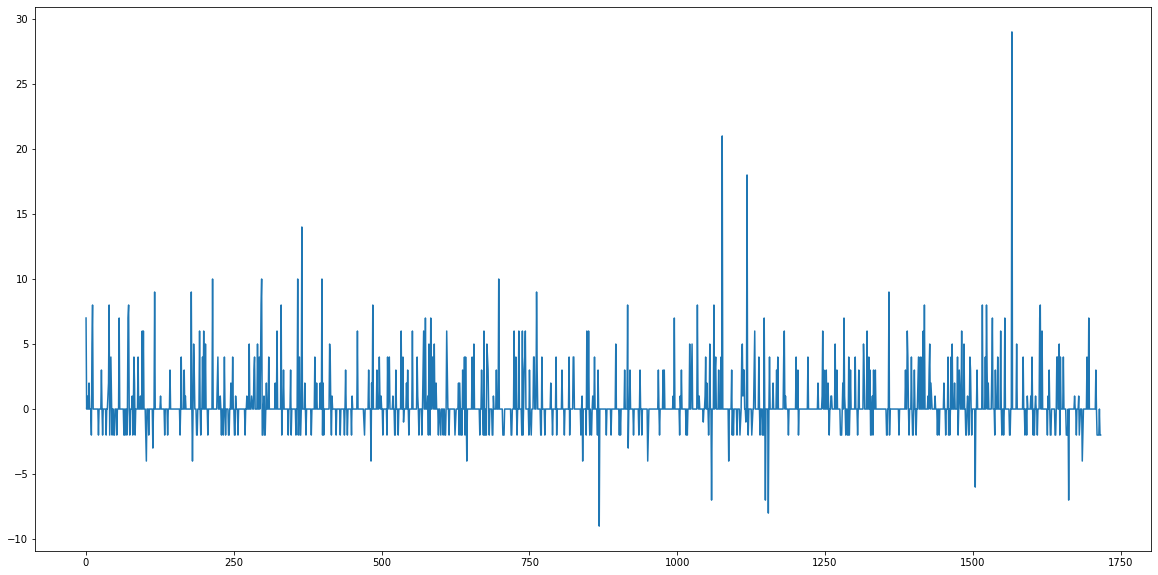

In [75]:
plt.plot(data['polaridad_CanDoBetter'])

Una vez extraida la información, podemos prescindir de la columna can do better.

In [57]:
data = data.drop(columns=['CanDoBetter'])
data.head()

,Training,Est_Income,Benefit,length_of_hire,SpousalBenefit,StockPlan,TrainingRecieved,Status,Facility_Facility A,Facility_Facility B,...,PositionType_Executive Management,PositionType_Non-Managerial/ Professional,PositionType_Sales,PositionType_Supervisor / Lead Tech.,"Education_Associate, High school, or Certification",Education_Baccalaureate or 4 year college degree,"Education_Doctorate (PhD, EdD, etc)",Education_Masters Degree,CanDoBetter_contains_freq_words,polaridad_CanDoBetter
0,True,60095.20000,True,58.479532,True,True,False,True,True,False,...,False,False,True,False,True,False,False,False,0.053878,7
1,True,47049.07979,False,35.714286,True,False,True,True,False,True,...,False,False,True,False,True,False,False,False,0.017762,0
2,True,60724.12250,True,17.152659,True,True,True,False,False,True,...,False,False,True,False,False,False,False,True,0.026643,1
3,False,63784.21843,True,5.271481,True,False,False,False,True,False,...,False,False,True,False,True,False,False,False,0.068680,0
4,False,87665.23353,False,4.244482,True,True,False,False,True,False,...,False,False,True,False,False,False,True,False,0.068680,0


Ahora todos los tipos son reconocibles para un arbol de decisión.

In [58]:
data.dtypes

Training                                                 bool
Est_Income                                            float64
Benefit                                                  bool
length_of_hire                                        float64
SpousalBenefit                                           bool
StockPlan                                                bool
TrainingRecieved                                         bool
Status                                                   bool
Facility_Facility A                                      bool
Facility_Facility B                                      bool
Facility_Facility C                                      bool
DriveTime_0-30 mnts                                      bool
DriveTime_30-60 mnts                                     bool
DriveTime_60-90 mnts                                     bool
DriveTime_More than 90 mnts                              bool
Marital_Married                                          bool
Marital_

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 0 to 1716
Data columns (total 30 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Training                                            1689 non-null   bool   
 1   Est_Income                                          1689 non-null   float64
 2   Benefit                                             1689 non-null   bool   
 3   length_of_hire                                      1689 non-null   float64
 4   SpousalBenefit                                      1689 non-null   bool   
 5   StockPlan                                           1689 non-null   bool   
 6   TrainingRecieved                                    1689 non-null   bool   
 7   Status                                              1689 non-null   bool   
 8   Facility_Facility A                                 1689 non-null   bool   
 9

Finalmente vemos como nos han quedado dos resgitros con nulos en length of hire y Est_Income. Al ser tan pocos regsitros, vamos a prescindir de ellos.                                        

In [60]:
data = data.dropna()

Ya no tenemos registros con nulos.

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 0 to 1716
Data columns (total 30 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Training                                            1689 non-null   bool   
 1   Est_Income                                          1689 non-null   float64
 2   Benefit                                             1689 non-null   bool   
 3   length_of_hire                                      1689 non-null   float64
 4   SpousalBenefit                                      1689 non-null   bool   
 5   StockPlan                                           1689 non-null   bool   
 6   TrainingRecieved                                    1689 non-null   bool   
 7   Status                                              1689 non-null   bool   
 8   Facility_Facility A                                 1689 non-null   bool   
 9

### Normalización

In [62]:
target = data.pop('Status').to_frame()
target

,Status
0,True
1,True
2,False
3,False
4,False
...,...
1712,False
1713,False
1714,False
1715,False


In [63]:
features = pd.DataFrame(
    StandardScaler().fit_transform(data), 
    columns = data.columns
)
features.head()

,Training,Est_Income,Benefit,length_of_hire,SpousalBenefit,StockPlan,TrainingRecieved,Facility_Facility A,Facility_Facility B,Facility_Facility C,...,PositionType_Executive Management,PositionType_Non-Managerial/ Professional,PositionType_Sales,PositionType_Supervisor / Lead Tech.,"Education_Associate, High school, or Certification",Education_Baccalaureate or 4 year college degree,"Education_Doctorate (PhD, EdD, etc)",Education_Masters Degree,CanDoBetter_contains_freq_words,polaridad_CanDoBetter
0,1.377347,-0.887150,1.357731,1.375862,2.262646,1.042959,-0.463797,1.225652,-1.192997,-0.11488,...,-0.320126,-1.212146,4.54465,-0.580769,1.695244,-0.616362,-0.533302,-0.56983,-0.425681,2.990774
1,1.377347,-1.673820,-0.736523,0.651261,2.262646,-0.958811,2.156114,-0.815892,0.838225,-0.11488,...,-0.320126,-1.212146,4.54465,-0.580769,1.695244,-0.616362,-0.533302,-0.56983,-1.087441,-0.187075
2,1.377347,-0.849226,1.357731,0.060458,2.262646,1.042959,2.156114,-0.815892,0.838225,-0.11488,...,-0.320126,-1.212146,4.54465,-0.580769,-0.589885,-0.616362,-0.533302,1.75491,-0.924713,0.266904
3,-0.726034,-0.664705,1.357731,-0.317711,2.262646,-0.958811,-0.463797,1.225652,-1.192997,-0.11488,...,-0.320126,-1.212146,4.54465,-0.580769,1.695244,-0.616362,-0.533302,-0.56983,-0.154468,-0.187075
4,-0.726034,0.775300,-0.736523,-0.350400,2.262646,1.042959,-0.463797,1.225652,-1.192997,-0.11488,...,-0.320126,-1.212146,4.54465,-0.580769,-0.589885,-0.616362,1.875111,-0.56983,-0.154468,-0.187075


# Modelo

### Desición Tree

In [64]:
tree_results_df = pd.DataFrame(columns=['particion_test', 'depth', 'criterion_type', 'splitter_type', 'max_features_type', 'train_score', 'test_score'])
tree_results_df.head()

,particion_test,depth,criterion_type,splitter_type,max_features_type,train_score,test_score


In [65]:
particion = 0.10

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=particion, random_state=random_state)

depths = range(1,20)
criterion_types = ['gini', 'entropy']
splitter_types = ['best', 'random']
max_features_types = ['auto', 'sqrt', 'log2']

for depth in depths:
    for criterion_type in criterion_types:
        for splitter_type in splitter_types:
            for max_features_type in max_features_types:
                dec_tree = tree.DecisionTreeClassifier(
                    random_state = random_state, 
                    criterion = criterion_type,
                    splitter = splitter_type,
                    max_features = max_features_type,
                    max_depth = depth
                ).fit(X_train, y_train)

                res_temp = pd.DataFrame([[
                    particion,
                    depth, 
                    criterion_type,
                    splitter_type, 
                    max_features_type, 
                    dec_tree.score(X_train, y_train),
                    dec_tree.score(X_test, y_test)
                ]], columns=['particion_test', 'depth', 'criterion_type', 'splitter_type', 'max_features_type', 'train_score', 'test_score'])

                tree_results_df = tree_results_df.append(res_temp)

tree_results_df = tree_results_df.reset_index(drop=True)

In [66]:
tree_results_df = tree_results_df.sort_values(by='test_score', ascending=False)
tree_results_df.head(10)

,particion_test,depth,criterion_type,splitter_type,max_features_type,train_score,test_score
174,0.1,15,entropy,best,auto,0.969079,0.869822
175,0.1,15,entropy,best,sqrt,0.969079,0.869822
223,0.1,19,entropy,best,sqrt,0.995395,0.857988
222,0.1,19,entropy,best,auto,0.995395,0.857988
210,0.1,18,entropy,best,auto,0.988816,0.857988
211,0.1,18,entropy,best,sqrt,0.988816,0.857988
217,0.1,19,gini,best,sqrt,0.999342,0.852071
216,0.1,19,gini,best,auto,0.999342,0.852071
103,0.1,9,entropy,best,sqrt,0.891447,0.852071
102,0.1,9,entropy,best,auto,0.891447,0.852071


##### Analisis del modelo más optimo
Vamos a aplicar el mismo procedimiento que anteriormente, nos quedamos con el mejor modelo y realizamos un analisis mas profundo. 

In [105]:
optimal_tree_config = tree_results_df.iloc[0]
optimal_tree_config

particion_test            0.1
depth                      15
criterion_type        entropy
splitter_type            best
max_features_type        auto
train_score          0.969079
test_score           0.869822
Name: 174, dtype: object

In [106]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=optimal_tree_config[0], random_state = random_state)

dec_tree_opt = tree.DecisionTreeClassifier(
                        random_state=random_state, 
                        criterion = optimal_tree_config[2],
                        splitter = optimal_tree_config[3],
                        max_features = optimal_tree_config[4],
                        max_depth = optimal_tree_config[1]
                    )
dec_tree_opt = dec_tree_opt.fit(X_train, y_train)
y_pred = dec_tree_opt.predict(X_test)

dec_tree_opt.score(X_test, y_test)

0.8698224852071006

In [107]:
mse(y_test, y_pred)

0.1301775147928994

In [108]:
mae(y_test, y_pred)

0.1301775147928994

In [109]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.89      0.82      0.85        78
        True       0.86      0.91      0.88        91

    accuracy                           0.87       169
   macro avg       0.87      0.87      0.87       169
weighted avg       0.87      0.87      0.87       169



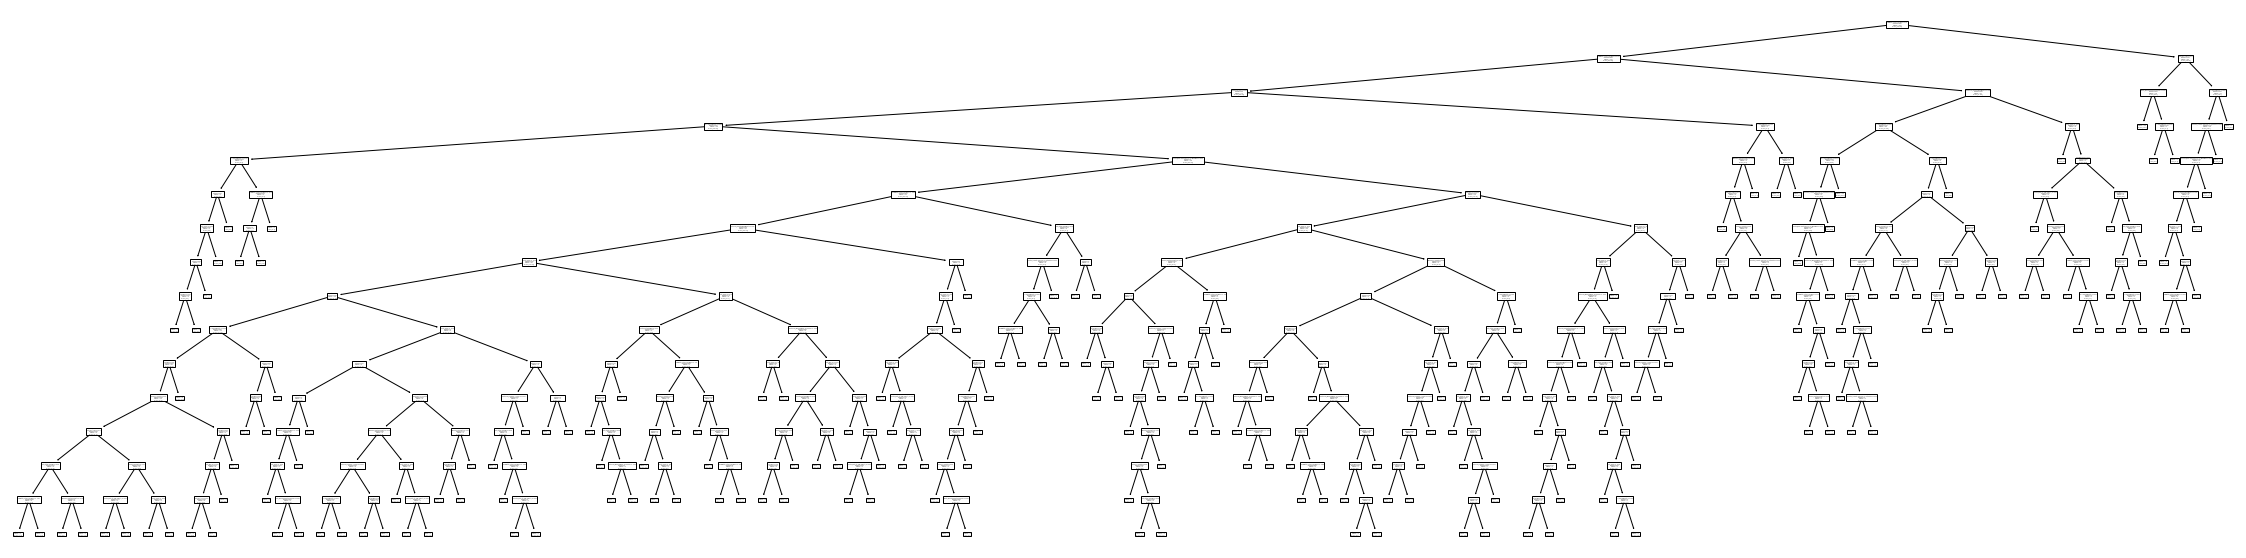

In [110]:
plt.figure(figsize=(40, 10))
tree.plot_tree(dec_tree_opt, feature_names = features.columns) 
plt.show()

AUC score: 0.8663003663003662


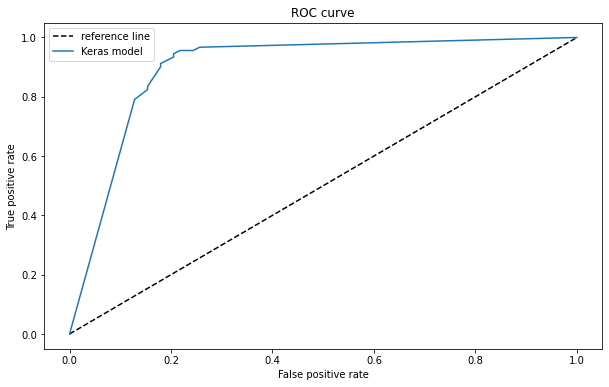

In [151]:
y_pred_prob = dec_tree_opt.predict_proba(X_test)  #probabilities for every prediction

fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:,1])
AUC_score = roc_auc_score(y_test, y_pred)
print('AUC score:', AUC_score)

plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--', label='reference line')
plt.plot(fpr, tpr, label='Keras model')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### KNN

In [101]:
knn_results_df = pd.DataFrame(columns=['particion_test', 'k_neighbors','train_score', 'test_score'])
knn_results_df.head()

,particion_test,k_neighbors,train_score,test_score


In [102]:

particion = [0.1,0.2,0.3,0.4,0.5,0.6]

for part in particion:
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=part, random_state=random_state)

    for n in range(1,10):
        knn = KNeighborsClassifier(n).fit(X_train, y_train)
        
        res_temp_knn = pd.DataFrame([[
                    part,
                    n, 
                    knn.score(X_train, y_train),
                    knn.score(X_test, y_test)
                ]], columns=['particion_test', 'k_neighbors','train_score', 'test_score'])
        
        knn_results_df = knn_results_df.append(res_temp_knn)

knn_results_df = knn_results_df.reset_index(drop=True)

In [103]:
knn_results_df = knn_results_df.sort_values(by='test_score', ascending=False)
knn_results_df.head(10)

,particion_test,k_neighbors,train_score,test_score
6,0.1,7,0.790789,0.745562
8,0.1,9,0.778289,0.733728
4,0.1,5,0.814474,0.733728
7,0.1,8,0.790132,0.721893
52,0.6,8,0.808889,0.709073
26,0.3,9,0.791032,0.708087
22,0.3,5,0.823181,0.708087
53,0.6,9,0.797037,0.705128
3,0.1,4,0.826316,0.704142
24,0.3,7,0.797800,0.702170


##### Analisis del modelo más optimo
Vamos a aplicar el mismo procedimiento que anteriormente, nos quedamos con el mejor modelo y realizamos un analisis mas profundo. 

In [152]:
particion = 0.10

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=particion, random_state=random_state)

n_neighbors = 7
knn = KNeighborsClassifier(n_neighbors)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))
print('mse score',mse(y_test, y_pred))
print('mae score',mae(y_test, y_pred))
print(metrics.classification_report(y_test,y_pred))

Accuracy of K-NN classifier on training set: 0.79
Accuracy of K-NN classifier on test set: 0.75
mse score 0.25443786982248523
mae score 0.25443786982248523
              precision    recall  f1-score   support

       False       0.81      0.59      0.68        78
        True       0.71      0.88      0.79        91

    accuracy                           0.75       169
   macro avg       0.76      0.73      0.73       169
weighted avg       0.76      0.75      0.74       169



AUC score: 0.7344322344322345


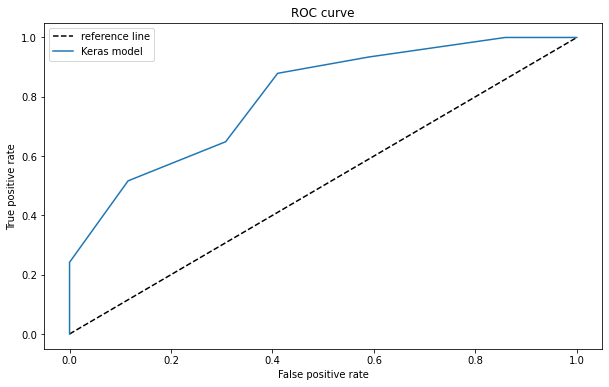

In [153]:
y_pred_prob = knn.predict_proba(X_test)  #probabilities for every prediction

fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:,1])
AUC_score = roc_auc_score(y_test, y_pred)
print('AUC score:', AUC_score)

plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--', label='reference line')
plt.plot(fpr, tpr, label='Keras model')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Red Neuronal

In [ ]:
red_results_df = pd.DataFrame(columns=['particion_test', 'k_neighbors','train_score', 'test_score'])
red_results_df.head()

In [187]:
particion = 0.20

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=particion, random_state=random_state)

tf.keras.backend.clear_session() # Esto libera el estado general de la memoria del sistema, utilizado en la creación del modelo y sus capas
tf.random.set_seed(11)
np.random.seed(11)


num_inputs = X_train.shape[1]

model = Sequential()

model.add(Dense(12, input_shape=(num_inputs,), activation='tanh')) 
model.add(Dense(8, activation='tanh')) 
model.add(Dense(1, activation='sigmoid'))  

model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

model.summary()

hist = model.fit(X_train,y_train, epochs=40, verbose=1, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                360       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 473
Trainable params: 473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
34/34 [==============================] - 0s 5ms/step - loss: 0.6295 - accuracy: 0.6534 - val_loss: 0.5724 - val_accuracy: 0.6937
Epoch 2/40
34/34 [==============================] - 0s 2ms/step - loss: 0.5700 - accuracy: 0.6883 - val_loss: 0.5614 - val_accuracy: 0.6753
Epoch 3/40
34/34 [==============================] - 0s 2ms/step - loss: 0.5642 - accuracy: 0.6959 - val_loss

In [226]:
def create_tf_xy_from_np (np_data, batch_size=32):
    """ Creación de un tensorflow anidado con X e y por lotes para entrenamiento en Keras
        Input:  np_data: matriz numpy con los datos. la variable target está en la última columna
                batch_size: medida del batch
    """

    #Convertimos a tensor anidado
    tf_data = tf.data.Dataset.from_tensor_slices(np_data)
    
    #Dentro del tensor anidado separamos en dos tensores => X e y
    tf_data = tf_data.map(lambda val: (val[:-1], [val[-1]])) 
    
    #Montamos los lotes
    tf_data = tf_data.batch(batch_size)
    
    return tf_data

In [227]:
red_results_df = pd.DataFrame(columns=['Total Epochs','neuronas_Hidden_layers_1','neuronas_Hidden_layers_2','Activación_Hidden_1','Activación_Hidden_1','Epoch','accuracy','val_accuracy'])
red_results_df.head()

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=random_state)

np_train = np.concatenate ((X_train, pd.DataFrame(y_train)), axis=1)
xy_train = create_tf_xy_from_np(np_train)
xy_test = create_tf_xy_from_np(np.concatenate ((X_test, pd.DataFrame(y_test)), axis=1))


act1 = ['tanh', 'relu']
act2 = ['sigmoid', 'softmax']
Epochs = [20,30,40]
neur1 = [8,14,20]
neur2 = [2,6,8]

for active1 in act1:
    for active2 in act2:
        for epoch in Epochs:
            for neu1 in neur1:
                for neu2 in neur2:
                    tf.keras.backend.clear_session()
                    tf.random.set_seed(11)
                    np.random.seed(11)

                    num_inputs = X_train.shape[1]

                    model = Sequential()

                    model.add(Dense(neu1, input_shape=(num_inputs,), activation=active1)) 
                    model.add(Dense(neu2, activation=active1)) 
                    model.add(Dense(1, activation=active2))  

                    model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

                    hist = model.fit(xy_train, epochs=epoch, verbose=1, validation_data=xy_test)

                    res_temp = pd.DataFrame([[
                        max(hist.epoch)+1,
                        neu1,
                        neu2,
                        active1,
                        active2,
                        (hist.history['val_accuracy'].index(max(hist.history['val_accuracy']))+1),
                        hist.history['accuracy'][hist.history['val_accuracy'].index(max(hist.history['val_accuracy']))], 
                        max(hist.history['val_accuracy']),
                    ]], columns=['Total Epochs','neuronas_Hidden_layers_1','neuronas_Hidden_layers_2','Activación_Hidden_1','Activación_Hidden_1','Epoch','accuracy','val_accuracy'])

                red_results_df = red_results_df.append(res_temp)

red_results_df = red_results_df.reset_index(drop=True)

Epoch 1/20
48/48 [==============================] - 0s 4ms/step - loss: 0.6638 - accuracy: 0.6223 - val_loss: 0.5996 - val_accuracy: 0.6805
Epoch 2/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5799 - accuracy: 0.6991 - val_loss: 0.5876 - val_accuracy: 0.6923
Epoch 3/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5600 - accuracy: 0.7089 - val_loss: 0.5871 - val_accuracy: 0.7041
Epoch 4/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5394 - accuracy: 0.7234 - val_loss: 0.5837 - val_accuracy: 0.7041
Epoch 5/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5205 - accuracy: 0.7428 - val_loss: 0.5787 - val_accuracy: 0.7041
Epoch 6/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5040 - accuracy: 0.7463 - val_loss: 0.5770 - val_accuracy: 0.7041
Epoch 7/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4893 - accuracy: 0.7584 - val_loss: 0.5812 - val_accuracy: 0.7101
Epoch 8/20
48/48 [==

48/48 [==============================] - 0s 2ms/step - loss: 0.3627 - accuracy: 0.8381 - val_loss: 0.5415 - val_accuracy: 0.7633
Epoch 20/20
48/48 [==============================] - 0s 2ms/step - loss: 0.3566 - accuracy: 0.8394 - val_loss: 0.5381 - val_accuracy: 0.7751
Epoch 1/20
48/48 [==============================] - 1s 4ms/step - loss: 0.7350 - accuracy: 0.5171 - val_loss: 0.5987 - val_accuracy: 0.6982
Epoch 2/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5817 - accuracy: 0.6929 - val_loss: 0.5854 - val_accuracy: 0.7101
Epoch 3/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5480 - accuracy: 0.7154 - val_loss: 0.5832 - val_accuracy: 0.7160
Epoch 4/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5220 - accuracy: 0.7317 - val_loss: 0.5847 - val_accuracy: 0.7219
Epoch 5/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4987 - accuracy: 0.7448 - val_loss: 0.5891 - val_accuracy: 0.7278
Epoch 6/20
48/48 [============

48/48 [==============================] - 0s 2ms/step - loss: 0.2030 - accuracy: 0.9158 - val_loss: 0.4105 - val_accuracy: 0.8284
Epoch 18/20
48/48 [==============================] - 0s 2ms/step - loss: 0.1928 - accuracy: 0.9219 - val_loss: 0.4112 - val_accuracy: 0.8343
Epoch 19/20
48/48 [==============================] - 0s 2ms/step - loss: 0.1846 - accuracy: 0.9249 - val_loss: 0.4126 - val_accuracy: 0.8284
Epoch 20/20
48/48 [==============================] - 0s 2ms/step - loss: 0.1770 - accuracy: 0.9355 - val_loss: 0.4185 - val_accuracy: 0.8284
Epoch 1/20
48/48 [==============================] - 0s 4ms/step - loss: 0.6640 - accuracy: 0.5998 - val_loss: 0.5872 - val_accuracy: 0.7101
Epoch 2/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5711 - accuracy: 0.7056 - val_loss: 0.5828 - val_accuracy: 0.7041
Epoch 3/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5383 - accuracy: 0.7307 - val_loss: 0.5664 - val_accuracy: 0.7219
Epoch 4/20
48/48 [==========

48/48 [==============================] - 0s 2ms/step - loss: 0.2368 - accuracy: 0.9093 - val_loss: 0.6907 - val_accuracy: 0.6982
Epoch 16/20
48/48 [==============================] - 0s 2ms/step - loss: 0.2281 - accuracy: 0.9154 - val_loss: 0.7211 - val_accuracy: 0.6982
Epoch 17/20
48/48 [==============================] - 0s 2ms/step - loss: 0.2184 - accuracy: 0.9225 - val_loss: 0.7607 - val_accuracy: 0.6923
Epoch 18/20
48/48 [==============================] - 0s 2ms/step - loss: 0.2081 - accuracy: 0.9297 - val_loss: 0.7922 - val_accuracy: 0.6805
Epoch 19/20
48/48 [==============================] - 0s 2ms/step - loss: 0.1997 - accuracy: 0.9268 - val_loss: 0.8116 - val_accuracy: 0.6864
Epoch 20/20
48/48 [==============================] - 0s 2ms/step - loss: 0.1930 - accuracy: 0.9320 - val_loss: 0.8127 - val_accuracy: 0.6923
Epoch 1/30
48/48 [==============================] - 0s 3ms/step - loss: 0.6638 - accuracy: 0.6223 - val_loss: 0.5996 - val_accuracy: 0.6805
Epoch 2/30
48/48 [========

48/48 [==============================] - 0s 2ms/step - loss: 0.3241 - accuracy: 0.8601 - val_loss: 0.5759 - val_accuracy: 0.7396
Epoch 24/30
48/48 [==============================] - 0s 2ms/step - loss: 0.3212 - accuracy: 0.8606 - val_loss: 0.5776 - val_accuracy: 0.7396
Epoch 25/30
48/48 [==============================] - 0s 2ms/step - loss: 0.3187 - accuracy: 0.8607 - val_loss: 0.5825 - val_accuracy: 0.7456
Epoch 26/30
48/48 [==============================] - 0s 2ms/step - loss: 0.3149 - accuracy: 0.8609 - val_loss: 0.5859 - val_accuracy: 0.7337
Epoch 27/30
48/48 [==============================] - 0s 2ms/step - loss: 0.3119 - accuracy: 0.8638 - val_loss: 0.5924 - val_accuracy: 0.7337
Epoch 28/30
48/48 [==============================] - 0s 2ms/step - loss: 0.3083 - accuracy: 0.8664 - val_loss: 0.5959 - val_accuracy: 0.7337
Epoch 29/30
48/48 [==============================] - 0s 2ms/step - loss: 0.3052 - accuracy: 0.8686 - val_loss: 0.6023 - val_accuracy: 0.7337
Epoch 30/30
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.3356 - accuracy: 0.8186 - val_loss: 0.6570 - val_accuracy: 0.7396
Epoch 22/30
48/48 [==============================] - 0s 2ms/step - loss: 0.3278 - accuracy: 0.8277 - val_loss: 0.6678 - val_accuracy: 0.7337
Epoch 23/30
48/48 [==============================] - 0s 2ms/step - loss: 0.3213 - accuracy: 0.8302 - val_loss: 0.6810 - val_accuracy: 0.7396
Epoch 24/30
48/48 [==============================] - 0s 2ms/step - loss: 0.3154 - accuracy: 0.8351 - val_loss: 0.6972 - val_accuracy: 0.7396
Epoch 25/30
48/48 [==============================] - 0s 2ms/step - loss: 0.3103 - accuracy: 0.8323 - val_loss: 0.7158 - val_accuracy: 0.7396
Epoch 26/30
48/48 [==============================] - 0s 2ms/step - loss: 0.3052 - accuracy: 0.8359 - val_loss: 0.7347 - val_accuracy: 0.7278
Epoch 27/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2987 - accuracy: 0.8393 - val_loss: 0.7544 - val_accuracy: 0.7278
Epoch 28/30
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.1846 - accuracy: 0.9249 - val_loss: 0.4126 - val_accuracy: 0.8284
Epoch 20/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1770 - accuracy: 0.9355 - val_loss: 0.4185 - val_accuracy: 0.8284
Epoch 21/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1716 - accuracy: 0.9288 - val_loss: 0.4273 - val_accuracy: 0.8225
Epoch 22/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1670 - accuracy: 0.9271 - val_loss: 0.4372 - val_accuracy: 0.8166
Epoch 23/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1618 - accuracy: 0.9329 - val_loss: 0.4507 - val_accuracy: 0.8166
Epoch 24/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1563 - accuracy: 0.9348 - val_loss: 0.4646 - val_accuracy: 0.8107
Epoch 25/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1499 - accuracy: 0.9369 - val_loss: 0.4843 - val_accuracy: 0.8047
Epoch 26/30
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.2681 - accuracy: 0.8827 - val_loss: 0.6615 - val_accuracy: 0.7337
Epoch 18/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2569 - accuracy: 0.8859 - val_loss: 0.6692 - val_accuracy: 0.7278
Epoch 19/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2463 - accuracy: 0.8912 - val_loss: 0.6782 - val_accuracy: 0.7456
Epoch 20/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2339 - accuracy: 0.8941 - val_loss: 0.6844 - val_accuracy: 0.7456
Epoch 21/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2231 - accuracy: 0.9051 - val_loss: 0.6893 - val_accuracy: 0.7278
Epoch 22/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2128 - accuracy: 0.9176 - val_loss: 0.6932 - val_accuracy: 0.7396
Epoch 23/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2035 - accuracy: 0.9175 - val_loss: 0.6995 - val_accuracy: 0.7456
Epoch 24/30
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.4145 - accuracy: 0.7993 - val_loss: 0.6633 - val_accuracy: 0.7101
Epoch 16/40
48/48 [==============================] - 0s 2ms/step - loss: 0.4104 - accuracy: 0.7994 - val_loss: 0.6732 - val_accuracy: 0.7101
Epoch 17/40
48/48 [==============================] - 0s 2ms/step - loss: 0.4051 - accuracy: 0.7998 - val_loss: 0.6796 - val_accuracy: 0.7041
Epoch 18/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3984 - accuracy: 0.7991 - val_loss: 0.6833 - val_accuracy: 0.6982
Epoch 19/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3926 - accuracy: 0.8031 - val_loss: 0.6873 - val_accuracy: 0.7041
Epoch 20/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3880 - accuracy: 0.8122 - val_loss: 0.6887 - val_accuracy: 0.7041
Epoch 21/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3846 - accuracy: 0.8077 - val_loss: 0.6934 - val_accuracy: 0.7101
Epoch 22/40
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.2944 - accuracy: 0.8779 - val_loss: 0.6262 - val_accuracy: 0.7456
Epoch 34/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2920 - accuracy: 0.8813 - val_loss: 0.6322 - val_accuracy: 0.7456
Epoch 35/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2898 - accuracy: 0.8844 - val_loss: 0.6385 - val_accuracy: 0.7515
Epoch 36/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2875 - accuracy: 0.8844 - val_loss: 0.6439 - val_accuracy: 0.7574
Epoch 37/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2854 - accuracy: 0.8860 - val_loss: 0.6499 - val_accuracy: 0.7456
Epoch 38/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2830 - accuracy: 0.8864 - val_loss: 0.6551 - val_accuracy: 0.7278
Epoch 39/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2804 - accuracy: 0.8866 - val_loss: 0.6617 - val_accuracy: 0.7219
Epoch 40/40
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.4063 - accuracy: 0.7846 - val_loss: 0.5963 - val_accuracy: 0.7396
Epoch 12/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3956 - accuracy: 0.7917 - val_loss: 0.6051 - val_accuracy: 0.7160
Epoch 13/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3866 - accuracy: 0.7992 - val_loss: 0.6124 - val_accuracy: 0.7160
Epoch 14/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3789 - accuracy: 0.8049 - val_loss: 0.6175 - val_accuracy: 0.7219
Epoch 15/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3715 - accuracy: 0.8095 - val_loss: 0.6221 - val_accuracy: 0.7337
Epoch 16/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3642 - accuracy: 0.8092 - val_loss: 0.6269 - val_accuracy: 0.7456
Epoch 17/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3586 - accuracy: 0.8115 - val_loss: 0.6351 - val_accuracy: 0.7396
Epoch 18/40
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.1485 - accuracy: 0.9498 - val_loss: 0.7237 - val_accuracy: 0.7811
Epoch 30/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1432 - accuracy: 0.9545 - val_loss: 0.7274 - val_accuracy: 0.7811
Epoch 31/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1386 - accuracy: 0.9566 - val_loss: 0.7274 - val_accuracy: 0.7811
Epoch 32/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1349 - accuracy: 0.9586 - val_loss: 0.7364 - val_accuracy: 0.7870
Epoch 33/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1305 - accuracy: 0.9598 - val_loss: 0.7380 - val_accuracy: 0.7988
Epoch 34/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1254 - accuracy: 0.9636 - val_loss: 0.7566 - val_accuracy: 0.7988
Epoch 35/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1217 - accuracy: 0.9608 - val_loss: 0.7673 - val_accuracy: 0.8047
Epoch 36/40
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.4251 - accuracy: 0.8128 - val_loss: 0.5511 - val_accuracy: 0.7574
Epoch 8/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3868 - accuracy: 0.8313 - val_loss: 0.5411 - val_accuracy: 0.7515
Epoch 9/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3439 - accuracy: 0.8518 - val_loss: 0.5289 - val_accuracy: 0.7870
Epoch 10/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3117 - accuracy: 0.8772 - val_loss: 0.5049 - val_accuracy: 0.7811
Epoch 11/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2874 - accuracy: 0.8881 - val_loss: 0.4942 - val_accuracy: 0.7988
Epoch 12/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2613 - accuracy: 0.9005 - val_loss: 0.4922 - val_accuracy: 0.7988
Epoch 13/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2414 - accuracy: 0.9033 - val_loss: 0.5049 - val_accuracy: 0.7929
Epoch 14/40
48/48 [========

48/48 [==============================] - 0s 2ms/step - loss: 0.1913 - accuracy: 0.9204 - val_loss: 0.7176 - val_accuracy: 0.7751
Epoch 26/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1861 - accuracy: 0.9247 - val_loss: 0.7339 - val_accuracy: 0.7692
Epoch 27/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1771 - accuracy: 0.9288 - val_loss: 0.7627 - val_accuracy: 0.7574
Epoch 28/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1694 - accuracy: 0.9331 - val_loss: 0.7838 - val_accuracy: 0.7515
Epoch 29/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1646 - accuracy: 0.9340 - val_loss: 0.8009 - val_accuracy: 0.7515
Epoch 30/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1600 - accuracy: 0.9363 - val_loss: 0.8311 - val_accuracy: 0.7515
Epoch 31/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1592 - accuracy: 0.9378 - val_loss: 0.8473 - val_accuracy: 0.7396
Epoch 32/40
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.5600 - accuracy: 0.5683 - val_loss: 0.5871 - val_accuracy: 0.5385
Epoch 4/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5394 - accuracy: 0.5683 - val_loss: 0.5837 - val_accuracy: 0.5385
Epoch 5/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5205 - accuracy: 0.5683 - val_loss: 0.5787 - val_accuracy: 0.5385
Epoch 6/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5040 - accuracy: 0.5683 - val_loss: 0.5770 - val_accuracy: 0.5385
Epoch 7/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4893 - accuracy: 0.5683 - val_loss: 0.5812 - val_accuracy: 0.5385
Epoch 8/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4762 - accuracy: 0.5683 - val_loss: 0.5902 - val_accuracy: 0.5385
Epoch 9/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4645 - accuracy: 0.5683 - val_loss: 0.6041 - val_accuracy: 0.5385
Epoch 10/20
48/48 [============

48/48 [==============================] - 0s 3ms/step - loss: 0.7350 - accuracy: 0.5683 - val_loss: 0.5987 - val_accuracy: 0.5385
Epoch 2/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5817 - accuracy: 0.5683 - val_loss: 0.5854 - val_accuracy: 0.5385
Epoch 3/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5480 - accuracy: 0.5683 - val_loss: 0.5832 - val_accuracy: 0.5385
Epoch 4/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5220 - accuracy: 0.5683 - val_loss: 0.5847 - val_accuracy: 0.5385
Epoch 5/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4987 - accuracy: 0.5683 - val_loss: 0.5891 - val_accuracy: 0.5385
Epoch 6/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4803 - accuracy: 0.5683 - val_loss: 0.5873 - val_accuracy: 0.5385
Epoch 7/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4646 - accuracy: 0.5683 - val_loss: 0.5817 - val_accuracy: 0.5385
Epoch 8/20
48/48 [=============

48/48 [==============================] - 0s 2ms/step - loss: 0.1846 - accuracy: 0.5683 - val_loss: 0.4126 - val_accuracy: 0.5385
Epoch 20/20
48/48 [==============================] - 0s 2ms/step - loss: 0.1770 - accuracy: 0.5683 - val_loss: 0.4185 - val_accuracy: 0.5385
Epoch 1/20
48/48 [==============================] - 0s 3ms/step - loss: 0.6640 - accuracy: 0.5683 - val_loss: 0.5872 - val_accuracy: 0.5385
Epoch 2/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5711 - accuracy: 0.5683 - val_loss: 0.5828 - val_accuracy: 0.5385
Epoch 3/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5383 - accuracy: 0.5683 - val_loss: 0.5664 - val_accuracy: 0.5385
Epoch 4/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5098 - accuracy: 0.5683 - val_loss: 0.5474 - val_accuracy: 0.5385
Epoch 5/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4812 - accuracy: 0.5683 - val_loss: 0.5433 - val_accuracy: 0.5385
Epoch 6/20
48/48 [============

48/48 [==============================] - 0s 2ms/step - loss: 0.2184 - accuracy: 0.5683 - val_loss: 0.7607 - val_accuracy: 0.5385
Epoch 18/20
48/48 [==============================] - 0s 2ms/step - loss: 0.2081 - accuracy: 0.5683 - val_loss: 0.7922 - val_accuracy: 0.5385
Epoch 19/20
48/48 [==============================] - 0s 2ms/step - loss: 0.1997 - accuracy: 0.5683 - val_loss: 0.8116 - val_accuracy: 0.5385
Epoch 20/20
48/48 [==============================] - 0s 2ms/step - loss: 0.1930 - accuracy: 0.5683 - val_loss: 0.8127 - val_accuracy: 0.5385
Epoch 1/30
48/48 [==============================] - 0s 3ms/step - loss: 0.6638 - accuracy: 0.5683 - val_loss: 0.5996 - val_accuracy: 0.5385
Epoch 2/30
48/48 [==============================] - 0s 2ms/step - loss: 0.5799 - accuracy: 0.5683 - val_loss: 0.5876 - val_accuracy: 0.5385
Epoch 3/30
48/48 [==============================] - 0s 2ms/step - loss: 0.5600 - accuracy: 0.5683 - val_loss: 0.5871 - val_accuracy: 0.5385
Epoch 4/30
48/48 [==========

48/48 [==============================] - 0s 2ms/step - loss: 0.3187 - accuracy: 0.5683 - val_loss: 0.5825 - val_accuracy: 0.5385
Epoch 26/30
48/48 [==============================] - 0s 2ms/step - loss: 0.3149 - accuracy: 0.5683 - val_loss: 0.5859 - val_accuracy: 0.5385
Epoch 27/30
48/48 [==============================] - 0s 2ms/step - loss: 0.3119 - accuracy: 0.5683 - val_loss: 0.5924 - val_accuracy: 0.5385
Epoch 28/30
48/48 [==============================] - 0s 2ms/step - loss: 0.3083 - accuracy: 0.5683 - val_loss: 0.5959 - val_accuracy: 0.5385
Epoch 29/30
48/48 [==============================] - 0s 2ms/step - loss: 0.3052 - accuracy: 0.5683 - val_loss: 0.6023 - val_accuracy: 0.5385
Epoch 30/30
48/48 [==============================] - 0s 2ms/step - loss: 0.3018 - accuracy: 0.5683 - val_loss: 0.6076 - val_accuracy: 0.5385
Epoch 1/30
48/48 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.5683 - val_loss: 0.5952 - val_accuracy: 0.5385
Epoch 2/30
48/48 [========

48/48 [==============================] - 0s 2ms/step - loss: 0.3213 - accuracy: 0.5683 - val_loss: 0.6810 - val_accuracy: 0.5385
Epoch 24/30
48/48 [==============================] - 0s 2ms/step - loss: 0.3154 - accuracy: 0.5683 - val_loss: 0.6972 - val_accuracy: 0.5385
Epoch 25/30
48/48 [==============================] - 0s 2ms/step - loss: 0.3103 - accuracy: 0.5683 - val_loss: 0.7158 - val_accuracy: 0.5385
Epoch 26/30
48/48 [==============================] - 0s 2ms/step - loss: 0.3052 - accuracy: 0.5683 - val_loss: 0.7347 - val_accuracy: 0.5385
Epoch 27/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2987 - accuracy: 0.5683 - val_loss: 0.7544 - val_accuracy: 0.5385
Epoch 28/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2936 - accuracy: 0.5683 - val_loss: 0.7728 - val_accuracy: 0.5385
Epoch 29/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2894 - accuracy: 0.5683 - val_loss: 0.7881 - val_accuracy: 0.5385
Epoch 30/30
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.1716 - accuracy: 0.5683 - val_loss: 0.4273 - val_accuracy: 0.5385
Epoch 22/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1670 - accuracy: 0.5683 - val_loss: 0.4372 - val_accuracy: 0.5385
Epoch 23/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1618 - accuracy: 0.5683 - val_loss: 0.4507 - val_accuracy: 0.5385
Epoch 24/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1563 - accuracy: 0.5683 - val_loss: 0.4646 - val_accuracy: 0.5385
Epoch 25/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1499 - accuracy: 0.5683 - val_loss: 0.4843 - val_accuracy: 0.5385
Epoch 26/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1428 - accuracy: 0.5683 - val_loss: 0.5047 - val_accuracy: 0.5385
Epoch 27/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1358 - accuracy: 0.5683 - val_loss: 0.5275 - val_accuracy: 0.5385
Epoch 28/30
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.2463 - accuracy: 0.5683 - val_loss: 0.6782 - val_accuracy: 0.5385
Epoch 20/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2339 - accuracy: 0.5683 - val_loss: 0.6844 - val_accuracy: 0.5385
Epoch 21/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2231 - accuracy: 0.5683 - val_loss: 0.6893 - val_accuracy: 0.5385
Epoch 22/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2128 - accuracy: 0.5683 - val_loss: 0.6932 - val_accuracy: 0.5385
Epoch 23/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2035 - accuracy: 0.5683 - val_loss: 0.6995 - val_accuracy: 0.5385
Epoch 24/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1969 - accuracy: 0.5683 - val_loss: 0.7066 - val_accuracy: 0.5385
Epoch 25/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1913 - accuracy: 0.5683 - val_loss: 0.7176 - val_accuracy: 0.5385
Epoch 26/30
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.4051 - accuracy: 0.5683 - val_loss: 0.6796 - val_accuracy: 0.5385
Epoch 18/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3984 - accuracy: 0.5683 - val_loss: 0.6833 - val_accuracy: 0.5385
Epoch 19/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3926 - accuracy: 0.5683 - val_loss: 0.6873 - val_accuracy: 0.5385
Epoch 20/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3880 - accuracy: 0.5683 - val_loss: 0.6887 - val_accuracy: 0.5385
Epoch 21/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3846 - accuracy: 0.5683 - val_loss: 0.6934 - val_accuracy: 0.5385
Epoch 22/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3814 - accuracy: 0.5683 - val_loss: 0.6965 - val_accuracy: 0.5385
Epoch 23/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3778 - accuracy: 0.5683 - val_loss: 0.7021 - val_accuracy: 0.5385
Epoch 24/40
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.2898 - accuracy: 0.5683 - val_loss: 0.6385 - val_accuracy: 0.5385
Epoch 36/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2875 - accuracy: 0.5683 - val_loss: 0.6439 - val_accuracy: 0.5385
Epoch 37/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2854 - accuracy: 0.5683 - val_loss: 0.6499 - val_accuracy: 0.5385
Epoch 38/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2830 - accuracy: 0.5683 - val_loss: 0.6551 - val_accuracy: 0.5385
Epoch 39/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2804 - accuracy: 0.5683 - val_loss: 0.6617 - val_accuracy: 0.5385
Epoch 40/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2774 - accuracy: 0.5683 - val_loss: 0.6675 - val_accuracy: 0.5385
Epoch 1/40
48/48 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.5683 - val_loss: 0.5952 - val_accuracy: 0.5385
Epoch 2/40
48/48 [========

48/48 [==============================] - 0s 2ms/step - loss: 0.3866 - accuracy: 0.5683 - val_loss: 0.6124 - val_accuracy: 0.5385
Epoch 14/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3789 - accuracy: 0.5683 - val_loss: 0.6175 - val_accuracy: 0.5385
Epoch 15/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3715 - accuracy: 0.5683 - val_loss: 0.6221 - val_accuracy: 0.5385
Epoch 16/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3642 - accuracy: 0.5683 - val_loss: 0.6269 - val_accuracy: 0.5385
Epoch 17/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3586 - accuracy: 0.5683 - val_loss: 0.6351 - val_accuracy: 0.5385
Epoch 18/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3550 - accuracy: 0.5683 - val_loss: 0.6415 - val_accuracy: 0.5385
Epoch 19/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3505 - accuracy: 0.5683 - val_loss: 0.6439 - val_accuracy: 0.5385
Epoch 20/40
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.1386 - accuracy: 0.5683 - val_loss: 0.7274 - val_accuracy: 0.5385
Epoch 32/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1349 - accuracy: 0.5683 - val_loss: 0.7364 - val_accuracy: 0.5385
Epoch 33/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1305 - accuracy: 0.5683 - val_loss: 0.7380 - val_accuracy: 0.5385
Epoch 34/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1254 - accuracy: 0.5683 - val_loss: 0.7566 - val_accuracy: 0.5385
Epoch 35/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1217 - accuracy: 0.5683 - val_loss: 0.7673 - val_accuracy: 0.5385
Epoch 36/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1161 - accuracy: 0.5683 - val_loss: 0.7843 - val_accuracy: 0.5385
Epoch 37/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1207 - accuracy: 0.5683 - val_loss: 0.7910 - val_accuracy: 0.5385
Epoch 38/40
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.3439 - accuracy: 0.5683 - val_loss: 0.5289 - val_accuracy: 0.5385
Epoch 10/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3117 - accuracy: 0.5683 - val_loss: 0.5049 - val_accuracy: 0.5385
Epoch 11/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2874 - accuracy: 0.5683 - val_loss: 0.4942 - val_accuracy: 0.5385
Epoch 12/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2613 - accuracy: 0.5683 - val_loss: 0.4922 - val_accuracy: 0.5385
Epoch 13/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2414 - accuracy: 0.5683 - val_loss: 0.5049 - val_accuracy: 0.5385
Epoch 14/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2266 - accuracy: 0.5683 - val_loss: 0.5337 - val_accuracy: 0.5385
Epoch 15/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2116 - accuracy: 0.5683 - val_loss: 0.5445 - val_accuracy: 0.5385
Epoch 16/40
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.1771 - accuracy: 0.5683 - val_loss: 0.7627 - val_accuracy: 0.5385
Epoch 28/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1694 - accuracy: 0.5683 - val_loss: 0.7838 - val_accuracy: 0.5385
Epoch 29/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1646 - accuracy: 0.5683 - val_loss: 0.8009 - val_accuracy: 0.5385
Epoch 30/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1600 - accuracy: 0.5683 - val_loss: 0.8311 - val_accuracy: 0.5385
Epoch 31/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1592 - accuracy: 0.5683 - val_loss: 0.8473 - val_accuracy: 0.5385
Epoch 32/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1537 - accuracy: 0.5683 - val_loss: 0.8604 - val_accuracy: 0.5385
Epoch 33/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1546 - accuracy: 0.5683 - val_loss: 0.8884 - val_accuracy: 0.5385
Epoch 34/40
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.5399 - accuracy: 0.7614 - val_loss: 0.5250 - val_accuracy: 0.7337
Epoch 6/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5290 - accuracy: 0.7600 - val_loss: 0.5190 - val_accuracy: 0.7396
Epoch 7/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5183 - accuracy: 0.7714 - val_loss: 0.5130 - val_accuracy: 0.7337
Epoch 8/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5008 - accuracy: 0.7865 - val_loss: 0.5095 - val_accuracy: 0.7515
Epoch 9/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4852 - accuracy: 0.7916 - val_loss: 0.5022 - val_accuracy: 0.7692
Epoch 10/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4541 - accuracy: 0.8100 - val_loss: 0.4898 - val_accuracy: 0.7751
Epoch 11/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4342 - accuracy: 0.8267 - val_loss: 0.4910 - val_accuracy: 0.7692
Epoch 12/20
48/48 [==========

48/48 [==============================] - 0s 2ms/step - loss: 0.5755 - accuracy: 0.7422 - val_loss: 0.5577 - val_accuracy: 0.7337
Epoch 4/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5145 - accuracy: 0.8055 - val_loss: 0.5337 - val_accuracy: 0.7456
Epoch 5/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4727 - accuracy: 0.8362 - val_loss: 0.5213 - val_accuracy: 0.7574
Epoch 6/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4450 - accuracy: 0.8381 - val_loss: 0.5011 - val_accuracy: 0.7574
Epoch 7/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4255 - accuracy: 0.8399 - val_loss: 0.4741 - val_accuracy: 0.7811
Epoch 8/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4019 - accuracy: 0.8471 - val_loss: 0.4573 - val_accuracy: 0.7929
Epoch 9/20
48/48 [==============================] - 0s 2ms/step - loss: 0.3787 - accuracy: 0.8611 - val_loss: 0.4422 - val_accuracy: 0.7988
Epoch 10/20
48/48 [============

48/48 [==============================] - 0s 3ms/step - loss: 0.7025 - accuracy: 0.6131 - val_loss: 0.5854 - val_accuracy: 0.7219
Epoch 2/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5843 - accuracy: 0.7457 - val_loss: 0.5483 - val_accuracy: 0.7278
Epoch 3/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5482 - accuracy: 0.7568 - val_loss: 0.5299 - val_accuracy: 0.7574
Epoch 4/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5160 - accuracy: 0.7879 - val_loss: 0.4997 - val_accuracy: 0.7929
Epoch 5/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4778 - accuracy: 0.8058 - val_loss: 0.4890 - val_accuracy: 0.7870
Epoch 6/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4444 - accuracy: 0.8286 - val_loss: 0.4827 - val_accuracy: 0.8166
Epoch 7/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4163 - accuracy: 0.8427 - val_loss: 0.4830 - val_accuracy: 0.8166
Epoch 8/20
48/48 [=============

48/48 [==============================] - 0s 2ms/step - loss: 0.2000 - accuracy: 0.9192 - val_loss: 0.6320 - val_accuracy: 0.7633
Epoch 20/20
48/48 [==============================] - 0s 2ms/step - loss: 0.1872 - accuracy: 0.9231 - val_loss: 0.6159 - val_accuracy: 0.7692
Epoch 1/30
48/48 [==============================] - 0s 3ms/step - loss: 0.7179 - accuracy: 0.5605 - val_loss: 0.6323 - val_accuracy: 0.6568
Epoch 2/30
48/48 [==============================] - 0s 2ms/step - loss: 0.6150 - accuracy: 0.6987 - val_loss: 0.5838 - val_accuracy: 0.6982
Epoch 3/30
48/48 [==============================] - 0s 2ms/step - loss: 0.5863 - accuracy: 0.7189 - val_loss: 0.5568 - val_accuracy: 0.7337
Epoch 4/30
48/48 [==============================] - 0s 2ms/step - loss: 0.5586 - accuracy: 0.7354 - val_loss: 0.5351 - val_accuracy: 0.7337
Epoch 5/30
48/48 [==============================] - 0s 2ms/step - loss: 0.5399 - accuracy: 0.7614 - val_loss: 0.5250 - val_accuracy: 0.7337
Epoch 6/30
48/48 [============

48/48 [==============================] - 0s 2ms/step - loss: 0.2823 - accuracy: 0.8913 - val_loss: 0.4066 - val_accuracy: 0.8343
Epoch 28/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2832 - accuracy: 0.8901 - val_loss: 0.4135 - val_accuracy: 0.8343
Epoch 29/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2784 - accuracy: 0.8958 - val_loss: 0.4126 - val_accuracy: 0.8402
Epoch 30/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2786 - accuracy: 0.8866 - val_loss: 0.4239 - val_accuracy: 0.8225
Epoch 1/30
48/48 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.6052 - val_loss: 0.5945 - val_accuracy: 0.6864
Epoch 2/30
48/48 [==============================] - 0s 2ms/step - loss: 0.5586 - accuracy: 0.7276 - val_loss: 0.5777 - val_accuracy: 0.6805
Epoch 3/30
48/48 [==============================] - 0s 2ms/step - loss: 0.5134 - accuracy: 0.7575 - val_loss: 0.5827 - val_accuracy: 0.7160
Epoch 4/30
48/48 [==========

48/48 [==============================] - 0s 2ms/step - loss: 0.2650 - accuracy: 0.9187 - val_loss: 0.4727 - val_accuracy: 0.8107
Epoch 26/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2638 - accuracy: 0.9148 - val_loss: 0.4823 - val_accuracy: 0.8047
Epoch 27/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2624 - accuracy: 0.9211 - val_loss: 0.4827 - val_accuracy: 0.8107
Epoch 28/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2611 - accuracy: 0.9194 - val_loss: 0.4925 - val_accuracy: 0.8225
Epoch 29/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2582 - accuracy: 0.9176 - val_loss: 0.5014 - val_accuracy: 0.8225
Epoch 30/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2557 - accuracy: 0.9210 - val_loss: 0.5184 - val_accuracy: 0.8047
Epoch 1/30
48/48 [==============================] - 0s 4ms/step - loss: 0.6733 - accuracy: 0.6353 - val_loss: 0.5950 - val_accuracy: 0.6686
Epoch 2/30
48/48 [========

48/48 [==============================] - 0s 2ms/step - loss: 0.2067 - accuracy: 0.9115 - val_loss: 0.6879 - val_accuracy: 0.7929
Epoch 24/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2043 - accuracy: 0.9106 - val_loss: 0.6515 - val_accuracy: 0.8107
Epoch 25/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1976 - accuracy: 0.9199 - val_loss: 0.7085 - val_accuracy: 0.8047
Epoch 26/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1965 - accuracy: 0.9062 - val_loss: 0.6908 - val_accuracy: 0.7929
Epoch 27/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1900 - accuracy: 0.9140 - val_loss: 0.7400 - val_accuracy: 0.8107
Epoch 28/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1832 - accuracy: 0.9140 - val_loss: 0.7519 - val_accuracy: 0.8225
Epoch 29/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1772 - accuracy: 0.9331 - val_loss: 0.6923 - val_accuracy: 0.7811
Epoch 30/30
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.2269 - accuracy: 0.9018 - val_loss: 0.5822 - val_accuracy: 0.7811
Epoch 22/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2231 - accuracy: 0.9075 - val_loss: 0.5533 - val_accuracy: 0.8047
Epoch 23/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2210 - accuracy: 0.9069 - val_loss: 0.5888 - val_accuracy: 0.7929
Epoch 24/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2170 - accuracy: 0.9078 - val_loss: 0.6097 - val_accuracy: 0.8047
Epoch 25/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2128 - accuracy: 0.9093 - val_loss: 0.6181 - val_accuracy: 0.7751
Epoch 26/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2076 - accuracy: 0.9107 - val_loss: 0.6406 - val_accuracy: 0.7988
Epoch 27/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2042 - accuracy: 0.9099 - val_loss: 0.6214 - val_accuracy: 0.7751
Epoch 28/30
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.3832 - accuracy: 0.8383 - val_loss: 0.4521 - val_accuracy: 0.7988
Epoch 20/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3774 - accuracy: 0.8459 - val_loss: 0.4519 - val_accuracy: 0.8047
Epoch 21/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3753 - accuracy: 0.8424 - val_loss: 0.4471 - val_accuracy: 0.7988
Epoch 22/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3719 - accuracy: 0.8484 - val_loss: 0.4497 - val_accuracy: 0.8047
Epoch 23/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3676 - accuracy: 0.8519 - val_loss: 0.4494 - val_accuracy: 0.7988
Epoch 24/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3634 - accuracy: 0.8544 - val_loss: 0.4490 - val_accuracy: 0.8047
Epoch 25/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3621 - accuracy: 0.8506 - val_loss: 0.4534 - val_accuracy: 0.8047
Epoch 26/40
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.2688 - accuracy: 0.8938 - val_loss: 0.4469 - val_accuracy: 0.8402
Epoch 38/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2679 - accuracy: 0.8959 - val_loss: 0.4389 - val_accuracy: 0.8343
Epoch 39/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2637 - accuracy: 0.9007 - val_loss: 0.4383 - val_accuracy: 0.8166
Epoch 40/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2630 - accuracy: 0.8967 - val_loss: 0.4376 - val_accuracy: 0.8166
Epoch 1/40
48/48 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.6052 - val_loss: 0.5945 - val_accuracy: 0.6864
Epoch 2/40
48/48 [==============================] - 0s 2ms/step - loss: 0.5586 - accuracy: 0.7276 - val_loss: 0.5777 - val_accuracy: 0.6805
Epoch 3/40
48/48 [==============================] - 0s 2ms/step - loss: 0.5134 - accuracy: 0.7575 - val_loss: 0.5827 - val_accuracy: 0.7160
Epoch 4/40
48/48 [==========

48/48 [==============================] - 0s 2ms/step - loss: 0.3232 - accuracy: 0.8891 - val_loss: 0.4458 - val_accuracy: 0.7988
Epoch 16/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3168 - accuracy: 0.8930 - val_loss: 0.4429 - val_accuracy: 0.8047
Epoch 17/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3105 - accuracy: 0.8990 - val_loss: 0.4398 - val_accuracy: 0.7929
Epoch 18/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3068 - accuracy: 0.8983 - val_loss: 0.4312 - val_accuracy: 0.8166
Epoch 19/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3013 - accuracy: 0.8989 - val_loss: 0.4346 - val_accuracy: 0.8107
Epoch 20/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2949 - accuracy: 0.8996 - val_loss: 0.4408 - val_accuracy: 0.7988
Epoch 21/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2877 - accuracy: 0.9038 - val_loss: 0.4465 - val_accuracy: 0.7870
Epoch 22/40
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.1909 - accuracy: 0.9341 - val_loss: 0.7067 - val_accuracy: 0.7396
Epoch 34/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1881 - accuracy: 0.9338 - val_loss: 0.7293 - val_accuracy: 0.7337
Epoch 35/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1900 - accuracy: 0.9337 - val_loss: 0.7145 - val_accuracy: 0.7515
Epoch 36/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1855 - accuracy: 0.9353 - val_loss: 0.7630 - val_accuracy: 0.7396
Epoch 37/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1853 - accuracy: 0.9347 - val_loss: 0.7319 - val_accuracy: 0.7574
Epoch 38/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1820 - accuracy: 0.9364 - val_loss: 0.7734 - val_accuracy: 0.7456
Epoch 39/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1841 - accuracy: 0.9361 - val_loss: 0.7307 - val_accuracy: 0.7515
Epoch 40/40
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.3445 - accuracy: 0.8712 - val_loss: 0.5166 - val_accuracy: 0.7988
Epoch 12/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3297 - accuracy: 0.8741 - val_loss: 0.5271 - val_accuracy: 0.7811
Epoch 13/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3266 - accuracy: 0.8714 - val_loss: 0.5459 - val_accuracy: 0.7751
Epoch 14/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3176 - accuracy: 0.8818 - val_loss: 0.5401 - val_accuracy: 0.7811
Epoch 15/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3102 - accuracy: 0.8885 - val_loss: 0.5644 - val_accuracy: 0.7633
Epoch 16/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3045 - accuracy: 0.8917 - val_loss: 0.5791 - val_accuracy: 0.7574
Epoch 17/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2946 - accuracy: 0.8997 - val_loss: 0.5918 - val_accuracy: 0.7515
Epoch 18/40
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.1951 - accuracy: 0.9143 - val_loss: 0.6269 - val_accuracy: 0.7988
Epoch 30/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1858 - accuracy: 0.9207 - val_loss: 0.6434 - val_accuracy: 0.7633
Epoch 31/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1860 - accuracy: 0.9160 - val_loss: 0.5392 - val_accuracy: 0.7811
Epoch 32/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1788 - accuracy: 0.9176 - val_loss: 0.6944 - val_accuracy: 0.7692
Epoch 33/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1955 - accuracy: 0.9109 - val_loss: 0.6448 - val_accuracy: 0.7751
Epoch 34/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1691 - accuracy: 0.9228 - val_loss: 0.5903 - val_accuracy: 0.7870
Epoch 35/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1519 - accuracy: 0.9325 - val_loss: 0.6380 - val_accuracy: 0.7692
Epoch 36/40
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.5183 - accuracy: 0.5683 - val_loss: 0.5130 - val_accuracy: 0.5385
Epoch 8/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5008 - accuracy: 0.5683 - val_loss: 0.5095 - val_accuracy: 0.5385
Epoch 9/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4852 - accuracy: 0.5683 - val_loss: 0.5022 - val_accuracy: 0.5385
Epoch 10/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4541 - accuracy: 0.5683 - val_loss: 0.4898 - val_accuracy: 0.5385
Epoch 11/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4342 - accuracy: 0.5683 - val_loss: 0.4910 - val_accuracy: 0.5385
Epoch 12/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4236 - accuracy: 0.5683 - val_loss: 0.4826 - val_accuracy: 0.5385
Epoch 13/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4188 - accuracy: 0.5683 - val_loss: 0.4893 - val_accuracy: 0.5385
Epoch 14/20
48/48 [========

48/48 [==============================] - 0s 2ms/step - loss: 0.4727 - accuracy: 0.5683 - val_loss: 0.5213 - val_accuracy: 0.5385
Epoch 6/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4450 - accuracy: 0.5683 - val_loss: 0.5011 - val_accuracy: 0.5385
Epoch 7/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4255 - accuracy: 0.5683 - val_loss: 0.4741 - val_accuracy: 0.5385
Epoch 8/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4019 - accuracy: 0.5683 - val_loss: 0.4573 - val_accuracy: 0.5385
Epoch 9/20
48/48 [==============================] - 0s 2ms/step - loss: 0.3787 - accuracy: 0.5683 - val_loss: 0.4422 - val_accuracy: 0.5385
Epoch 10/20
48/48 [==============================] - 0s 2ms/step - loss: 0.3616 - accuracy: 0.5683 - val_loss: 0.4308 - val_accuracy: 0.5385
Epoch 11/20
48/48 [==============================] - 0s 2ms/step - loss: 0.3474 - accuracy: 0.5683 - val_loss: 0.4320 - val_accuracy: 0.5385
Epoch 12/20
48/48 [==========

48/48 [==============================] - 0s 2ms/step - loss: 0.5482 - accuracy: 0.5683 - val_loss: 0.5299 - val_accuracy: 0.5385
Epoch 4/20
48/48 [==============================] - 0s 2ms/step - loss: 0.5160 - accuracy: 0.5683 - val_loss: 0.4997 - val_accuracy: 0.5385
Epoch 5/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4778 - accuracy: 0.5683 - val_loss: 0.4890 - val_accuracy: 0.5385
Epoch 6/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4444 - accuracy: 0.5683 - val_loss: 0.4827 - val_accuracy: 0.5385
Epoch 7/20
48/48 [==============================] - 0s 2ms/step - loss: 0.4163 - accuracy: 0.5683 - val_loss: 0.4830 - val_accuracy: 0.5385
Epoch 8/20
48/48 [==============================] - 0s 2ms/step - loss: 0.3912 - accuracy: 0.5683 - val_loss: 0.4995 - val_accuracy: 0.5385
Epoch 9/20
48/48 [==============================] - 0s 2ms/step - loss: 0.3774 - accuracy: 0.5683 - val_loss: 0.5071 - val_accuracy: 0.5385
Epoch 10/20
48/48 [============

48/48 [==============================] - 0s 3ms/step - loss: 0.7179 - accuracy: 0.5683 - val_loss: 0.6323 - val_accuracy: 0.5385
Epoch 2/30
48/48 [==============================] - 0s 2ms/step - loss: 0.6150 - accuracy: 0.5683 - val_loss: 0.5838 - val_accuracy: 0.5385
Epoch 3/30
48/48 [==============================] - 0s 2ms/step - loss: 0.5863 - accuracy: 0.5683 - val_loss: 0.5568 - val_accuracy: 0.5385
Epoch 4/30
48/48 [==============================] - 0s 2ms/step - loss: 0.5586 - accuracy: 0.5683 - val_loss: 0.5351 - val_accuracy: 0.5385
Epoch 5/30
48/48 [==============================] - 0s 2ms/step - loss: 0.5399 - accuracy: 0.5683 - val_loss: 0.5250 - val_accuracy: 0.5385
Epoch 6/30
48/48 [==============================] - 0s 2ms/step - loss: 0.5290 - accuracy: 0.5683 - val_loss: 0.5190 - val_accuracy: 0.5385
Epoch 7/30
48/48 [==============================] - 0s 2ms/step - loss: 0.5183 - accuracy: 0.5683 - val_loss: 0.5130 - val_accuracy: 0.5385
Epoch 8/30
48/48 [=============

48/48 [==============================] - 0s 2ms/step - loss: 0.2784 - accuracy: 0.5683 - val_loss: 0.4126 - val_accuracy: 0.5385
Epoch 30/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2786 - accuracy: 0.5683 - val_loss: 0.4239 - val_accuracy: 0.5385
Epoch 1/30
48/48 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.5683 - val_loss: 0.5945 - val_accuracy: 0.5385
Epoch 2/30
48/48 [==============================] - 0s 2ms/step - loss: 0.5586 - accuracy: 0.5683 - val_loss: 0.5777 - val_accuracy: 0.5385
Epoch 3/30
48/48 [==============================] - 0s 2ms/step - loss: 0.5134 - accuracy: 0.5683 - val_loss: 0.5827 - val_accuracy: 0.5385
Epoch 4/30
48/48 [==============================] - 0s 2ms/step - loss: 0.4837 - accuracy: 0.5683 - val_loss: 0.5796 - val_accuracy: 0.5385
Epoch 5/30
48/48 [==============================] - 0s 2ms/step - loss: 0.4623 - accuracy: 0.5683 - val_loss: 0.5551 - val_accuracy: 0.5385
Epoch 6/30
48/48 [============

48/48 [==============================] - 0s 2ms/step - loss: 0.2624 - accuracy: 0.5683 - val_loss: 0.4827 - val_accuracy: 0.5385
Epoch 28/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2611 - accuracy: 0.5683 - val_loss: 0.4925 - val_accuracy: 0.5385
Epoch 29/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2582 - accuracy: 0.5683 - val_loss: 0.5014 - val_accuracy: 0.5385
Epoch 30/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2557 - accuracy: 0.5683 - val_loss: 0.5184 - val_accuracy: 0.5385
Epoch 1/30
48/48 [==============================] - 0s 3ms/step - loss: 0.6733 - accuracy: 0.5683 - val_loss: 0.5950 - val_accuracy: 0.5385
Epoch 2/30
48/48 [==============================] - 0s 2ms/step - loss: 0.5489 - accuracy: 0.5683 - val_loss: 0.5819 - val_accuracy: 0.5385
Epoch 3/30
48/48 [==============================] - 0s 2ms/step - loss: 0.5100 - accuracy: 0.5683 - val_loss: 0.5849 - val_accuracy: 0.5385
Epoch 4/30
48/48 [==========

48/48 [==============================] - 0s 2ms/step - loss: 0.1976 - accuracy: 0.5683 - val_loss: 0.7085 - val_accuracy: 0.5385
Epoch 26/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1965 - accuracy: 0.5683 - val_loss: 0.6908 - val_accuracy: 0.5385
Epoch 27/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1900 - accuracy: 0.5683 - val_loss: 0.7400 - val_accuracy: 0.5385
Epoch 28/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1832 - accuracy: 0.5683 - val_loss: 0.7519 - val_accuracy: 0.5385
Epoch 29/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1772 - accuracy: 0.5683 - val_loss: 0.6923 - val_accuracy: 0.5385
Epoch 30/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1812 - accuracy: 0.5683 - val_loss: 0.7787 - val_accuracy: 0.5385
Epoch 1/30
48/48 [==============================] - 0s 4ms/step - loss: 0.7025 - accuracy: 0.5683 - val_loss: 0.5854 - val_accuracy: 0.5385
Epoch 2/30
48/48 [========

48/48 [==============================] - 0s 2ms/step - loss: 0.2210 - accuracy: 0.5683 - val_loss: 0.5888 - val_accuracy: 0.5385
Epoch 24/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2170 - accuracy: 0.5683 - val_loss: 0.6097 - val_accuracy: 0.5385
Epoch 25/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2128 - accuracy: 0.5683 - val_loss: 0.6181 - val_accuracy: 0.5385
Epoch 26/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2076 - accuracy: 0.5683 - val_loss: 0.6406 - val_accuracy: 0.5385
Epoch 27/30
48/48 [==============================] - 0s 2ms/step - loss: 0.2042 - accuracy: 0.5683 - val_loss: 0.6214 - val_accuracy: 0.5385
Epoch 28/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1974 - accuracy: 0.5683 - val_loss: 0.6179 - val_accuracy: 0.5385
Epoch 29/30
48/48 [==============================] - 0s 2ms/step - loss: 0.1951 - accuracy: 0.5683 - val_loss: 0.6269 - val_accuracy: 0.5385
Epoch 30/30
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.3753 - accuracy: 0.5683 - val_loss: 0.4471 - val_accuracy: 0.5385
Epoch 22/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3719 - accuracy: 0.5683 - val_loss: 0.4497 - val_accuracy: 0.5385
Epoch 23/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3676 - accuracy: 0.5683 - val_loss: 0.4494 - val_accuracy: 0.5385
Epoch 24/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3634 - accuracy: 0.5683 - val_loss: 0.4490 - val_accuracy: 0.5385
Epoch 25/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3621 - accuracy: 0.5683 - val_loss: 0.4534 - val_accuracy: 0.5385
Epoch 26/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3584 - accuracy: 0.5683 - val_loss: 0.4516 - val_accuracy: 0.5385
Epoch 27/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3539 - accuracy: 0.5683 - val_loss: 0.4545 - val_accuracy: 0.5385
Epoch 28/40
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.2637 - accuracy: 0.5683 - val_loss: 0.4383 - val_accuracy: 0.5385
Epoch 40/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2630 - accuracy: 0.5683 - val_loss: 0.4376 - val_accuracy: 0.5385
Epoch 1/40
48/48 [==============================] - 0s 4ms/step - loss: 0.6673 - accuracy: 0.5683 - val_loss: 0.5945 - val_accuracy: 0.5385
Epoch 2/40
48/48 [==============================] - 0s 2ms/step - loss: 0.5586 - accuracy: 0.5683 - val_loss: 0.5777 - val_accuracy: 0.5385
Epoch 3/40
48/48 [==============================] - 0s 2ms/step - loss: 0.5134 - accuracy: 0.5683 - val_loss: 0.5827 - val_accuracy: 0.5385
Epoch 4/40
48/48 [==============================] - 0s 2ms/step - loss: 0.4837 - accuracy: 0.5683 - val_loss: 0.5796 - val_accuracy: 0.5385
Epoch 5/40
48/48 [==============================] - 0s 2ms/step - loss: 0.4623 - accuracy: 0.5683 - val_loss: 0.5551 - val_accuracy: 0.5385
Epoch 6/40
48/48 [============

48/48 [==============================] - 0s 2ms/step - loss: 0.3105 - accuracy: 0.5683 - val_loss: 0.4398 - val_accuracy: 0.5385
Epoch 18/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3068 - accuracy: 0.5683 - val_loss: 0.4312 - val_accuracy: 0.5385
Epoch 19/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3013 - accuracy: 0.5683 - val_loss: 0.4346 - val_accuracy: 0.5385
Epoch 20/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2949 - accuracy: 0.5683 - val_loss: 0.4408 - val_accuracy: 0.5385
Epoch 21/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2877 - accuracy: 0.5683 - val_loss: 0.4465 - val_accuracy: 0.5385
Epoch 22/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2817 - accuracy: 0.5683 - val_loss: 0.4436 - val_accuracy: 0.5385
Epoch 23/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2760 - accuracy: 0.5683 - val_loss: 0.4545 - val_accuracy: 0.5385
Epoch 24/40
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.1900 - accuracy: 0.5683 - val_loss: 0.7145 - val_accuracy: 0.5385
Epoch 36/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1855 - accuracy: 0.5683 - val_loss: 0.7630 - val_accuracy: 0.5385
Epoch 37/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1853 - accuracy: 0.5683 - val_loss: 0.7319 - val_accuracy: 0.5385
Epoch 38/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1820 - accuracy: 0.5683 - val_loss: 0.7734 - val_accuracy: 0.5385
Epoch 39/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1841 - accuracy: 0.5683 - val_loss: 0.7307 - val_accuracy: 0.5385
Epoch 40/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1748 - accuracy: 0.5683 - val_loss: 0.7524 - val_accuracy: 0.5385
Epoch 1/40
48/48 [==============================] - 0s 4ms/step - loss: 0.6557 - accuracy: 0.5683 - val_loss: 0.5888 - val_accuracy: 0.5385
Epoch 2/40
48/48 [========

48/48 [==============================] - 0s 2ms/step - loss: 0.3266 - accuracy: 0.5683 - val_loss: 0.5459 - val_accuracy: 0.5385
Epoch 14/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3176 - accuracy: 0.5683 - val_loss: 0.5401 - val_accuracy: 0.5385
Epoch 15/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3102 - accuracy: 0.5683 - val_loss: 0.5644 - val_accuracy: 0.5385
Epoch 16/40
48/48 [==============================] - 0s 2ms/step - loss: 0.3045 - accuracy: 0.5683 - val_loss: 0.5791 - val_accuracy: 0.5385
Epoch 17/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2946 - accuracy: 0.5683 - val_loss: 0.5918 - val_accuracy: 0.5385
Epoch 18/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2847 - accuracy: 0.5683 - val_loss: 0.6079 - val_accuracy: 0.5385
Epoch 19/40
48/48 [==============================] - 0s 2ms/step - loss: 0.2799 - accuracy: 0.5683 - val_loss: 0.6392 - val_accuracy: 0.5385
Epoch 20/40
48/48 [======

48/48 [==============================] - 0s 2ms/step - loss: 0.1860 - accuracy: 0.5683 - val_loss: 0.5392 - val_accuracy: 0.5385
Epoch 32/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1788 - accuracy: 0.5683 - val_loss: 0.6944 - val_accuracy: 0.5385
Epoch 33/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1955 - accuracy: 0.5683 - val_loss: 0.6448 - val_accuracy: 0.5385
Epoch 34/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1691 - accuracy: 0.5683 - val_loss: 0.5903 - val_accuracy: 0.5385
Epoch 35/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1519 - accuracy: 0.5683 - val_loss: 0.6380 - val_accuracy: 0.5385
Epoch 36/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1510 - accuracy: 0.5683 - val_loss: 0.6720 - val_accuracy: 0.5385
Epoch 37/40
48/48 [==============================] - 0s 2ms/step - loss: 0.1549 - accuracy: 0.5683 - val_loss: 0.6534 - val_accuracy: 0.5385
Epoch 38/40
48/48 [======

In [228]:
red_results_df = red_results_df.sort_values(by='val_accuracy', ascending=False)
red_results_df.head(10)

,Total Epochs,neuronas_Hidden_layers_1,neuronas_Hidden_layers_2,Activación_Hidden_1,Activación_Hidden_1,Epoch,accuracy,val_accuracy
24,40,8,8,relu,sigmoid,38,0.890132,0.863905
1,20,14,8,tanh,sigmoid,16,0.909211,0.840237
4,30,14,8,tanh,sigmoid,16,0.909211,0.840237
7,40,14,8,tanh,sigmoid,16,0.909211,0.840237
25,40,14,8,relu,sigmoid,14,0.882237,0.828402
22,30,14,8,relu,sigmoid,14,0.882237,0.828402
19,20,14,8,relu,sigmoid,14,0.882237,0.828402
26,40,20,8,relu,sigmoid,39,0.946711,0.822485
21,30,8,8,relu,sigmoid,28,0.881579,0.822485
18,20,8,8,relu,sigmoid,17,0.861184,0.816568


##### Analisis del modelo más optimo
Vamos a aplicar el mismo procedimiento que anteriormente, nos quedamos con el mejor modelo y realizamos un analisis mas profundo. 

In [231]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=random_state)

np_train = np.concatenate ((X_train, pd.DataFrame(y_train)), axis=1)
xy_train = create_tf_xy_from_np(np_train)
xy_test = create_tf_xy_from_np(np.concatenate ((X_test, pd.DataFrame(y_test)), axis=1))

tf.keras.backend.clear_session() # Esto libera el estado general de la memoria del sistema, utilizado en la creación del modelo y sus capas
tf.random.set_seed(11)
np.random.seed(11)


num_inputs = X_train.shape[1]

model = Sequential()

model.add(Dense(8, input_shape=(num_inputs,), activation='relu')) 
model.add(Dense(8, activation='relu')) 
model.add(Dense(1, activation='sigmoid'))  

model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

model.summary()

hist = model.fit(xy_train, epochs=40, verbose=1, validation_data=xy_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 240       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
48/48 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.6052 - val_loss: 0.5945 - val_accuracy: 0.6864
Epoch 2/40
48/48 [==============================] - 0s 2ms/step - loss: 0.5586 - accuracy: 0.7276 - val_loss: 0.5777 - val_accuracy: 0.6805
Epoch 3/40
48/48 [==============================] - 0s 2ms/step - loss: 0.5134 - accuracy: 0.7575 - val_loss

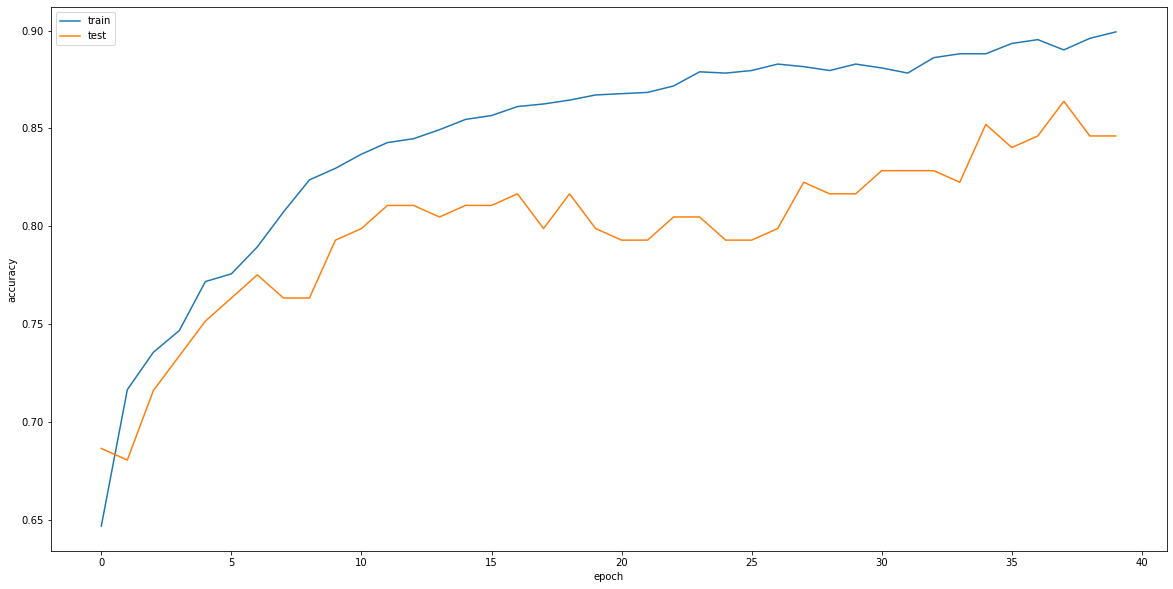

In [232]:
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='test')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

In [234]:
y_pred = model.predict_classes(X_test)

from sklearn.metrics import confusion_matrix, plot_confusion_matrix

print('\033[1m' + 'Confusion Matrix for Keras Model','\033[0m', '\n')

cm = confusion_matrix(y_test, y_pred)
print(cm)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support,classification_report

print('\n\033[1m' + 'Accuracy for Keras Model','\033[0m', '\n')

print ('Accuracy: ', accuracy_score(y_test, y_pred) )

#print(precision_recall_fscore_support(y_test, y_pred_tr)) # another way less beatiful than next
print(classification_report(y_test, y_pred))

Confusion Matrix for Keras Model  

[[62 16]
 [10 81]]

Accuracy for Keras Model  

Accuracy:  0.8461538461538461
              precision    recall  f1-score   support

       False       0.86      0.79      0.83        78
        True       0.84      0.89      0.86        91

    accuracy                           0.85       169
   macro avg       0.85      0.84      0.84       169
weighted avg       0.85      0.85      0.85       169



AUC score: 0.8424908424908425


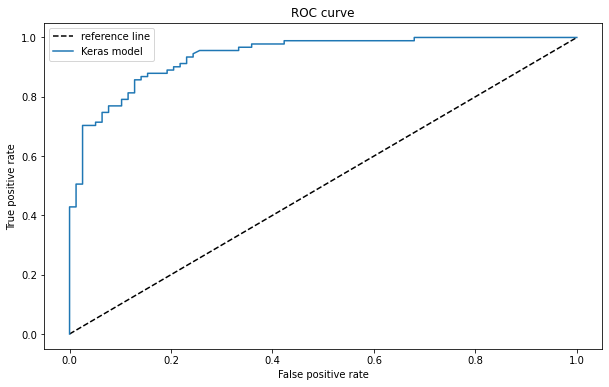

In [236]:
y_pred_prob = model.predict_proba(X_test)  #probabilities for every prediction

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
AUC_score = roc_auc_score(y_test, y_pred)
print('AUC score:', AUC_score)

plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--', label='reference line')
plt.plot(fpr, tpr, label='Keras model')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()